# **Catatan**

- Kode program 1 adalah kalian tinggal running kode ini agar dapat melihat training dengan data asli tanpa dibersihkan, kemudian dievaluasi hasilnya dan dicatat. (running sendiri ya, kalau ada error screenshot kirim ke wa saya)
- hasil training dengan data asli (classification non-tuning) dibandingkan dengan hasil training data asli menggunakan hyperparameter tuning
- metric evaluasinya harus ada accuracy, precision, recall, dan f1-score

Kode ini untuk Topik ini:
- Phishing URL Detection Using BERT-Based Transformer Models
Topik Riset:
"Deteksi URL Phishing dengan Model Transformer Berbasis BERT: Studi Kasus Analisis URL dan Email"
Deskripsi:
Model BERT (Bidirectional Encoder Representations from Transformers) digunakan untuk memahami konteks URL atau teks email yang mencurigakan. Model ini dapat menganalisis karakter URL dan teks email untuk membedakan apakah mereka merupakan phishing atau tidak berdasarkan pola yang diidentifikasi dari dataset phishing.
Novelty: Sedang. Meskipun deteksi phishing berbasis URL sudah diteliti cukup luas, penggunaan BERT untuk klasifikasi URL secara mendalam masih relatif baru. Namun, karena banyak model sudah menggunakan BERT untuk analisis teks, tingkat novelty bisa lebih tinggi jika dilakukan kombinasi fitur tambahan seperti analisis perilaku pengguna.
Dataset: Malicious URL Dataset
Dataset ini berisi jutaan URL berbahaya, termasuk yang digunakan untuk phishing. BERT, sebagai model Transformer, dapat digunakan untuk memahami pola karakteristik URL dan memprediksi kemungkinan serangan phishing.
URL: Malicious URL Dataset​(GitHub)


# **Importing Modules and Libraries**

In [6]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
import pickle

# Sklearn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW

# Transformers and progress bar
import transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    BertConfig,
    BertModel,
    AdamW
)
from tqdm.auto import tqdm
from contextlib import nullcontext
import json


In [ ]:
# !pip install transformers tensorflow scikit-learn matplotlib pandas
# !pip install transformers


# **Importing Datasets**

Mount Google Drive:

Digunakan untuk mengakses file yang disimpan di Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls


Mounted at /content/gdrive
gdrive	sample_data


Mengubah direktori kerja:

Ini digunakan untuk berpindah ke folder tempat dataset Anda berada.

In [2]:
import os
os.chdir("/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset")
!ls


 best_hyperparams_datadefault0.json   model_best_fold_2_state_dict.pt
 best_hyperparams_datadefault1.json   model_best_fold_3
 best_hyperparams_datadefault.json    model_best_fold_3_state_dict.pt
 classification_report.txt	      model_best_fold_4
 malicious_phish.csv		      model_best_fold_4_state_dict.pt
 Model				      model_best_fold_5
 model_best_fold_1		      model_best_fold_5_state_dict.pt
 model_best_fold_1_state_dict.pt     'Salinan best_hyperparams_datadefault.json'
 model_best_fold_2


Memuat dataset:

Dataset **malicious_phish.csv** dimuat ke dalam variabel data.

In [7]:
data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
print("Jumlah data asli:", len(data))
# data = data.sample(frac=0.0001, random_state=42).reset_index(drop=True)

# Mengambil xx% dari data secara acak
# ini sementara dilakukan karena resource yang dimiliki terbatas


Jumlah data asli: 651191


Menampilkan informasi awal tentang data:

Menampilkan 5 baris pertama dari dataset dan informasi tentang tipe data, jumlah entri, dan kolom yang ada di dalam dataset.

In [ ]:
data.head(n=5)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# Misalkan kolom yang berisi label adalah 'type'
# Menampilkan nilai unik dan jumlah setiap kelas
kelas = data['type'].value_counts()
print(kelas)

# Menampilkan jumlah kelas unik
jumlah_kelas = data['type'].nunique()
print(f"Jumlah kelas unik: {jumlah_kelas}")


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64
Jumlah kelas unik: 4


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
# Dimensions of the datasets after drop '-' in service column
print("(rows, columns):", data.shape)

(rows, columns): (651191, 2)


Ini adalah proses atau tahapan persiapan data yang baik sebelum dilanjutkan ke tahap analisis atau pemodelan.

# **EDA**

In [ ]:
print(data.columns)


Index(['url', 'type'], dtype='object')


In [ ]:
print(data['type'].value_counts())


type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


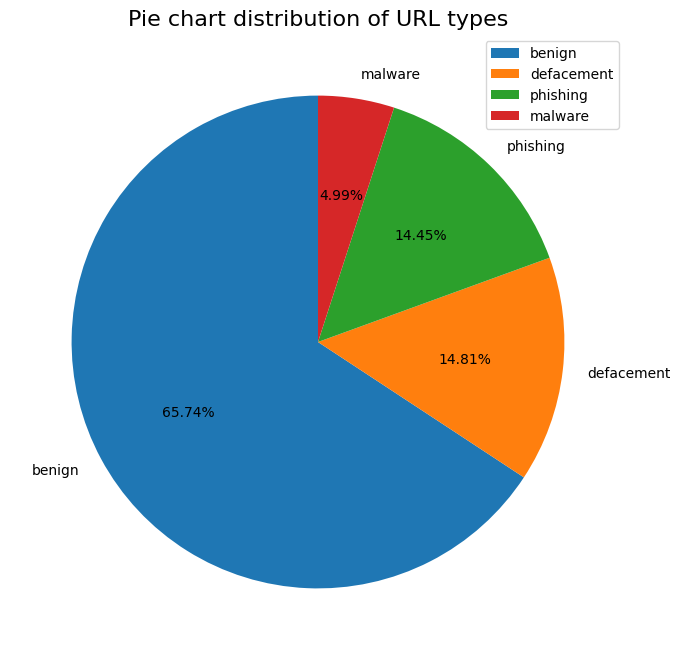

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset

# Hitung distribusi semua label
label_counts = data['type'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of URL types", fontsize=16)
plt.legend()
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Pie_chart_all_classes.png')
plt.show()


<ipython-input-9-21c6c7a778f4>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='Set2')


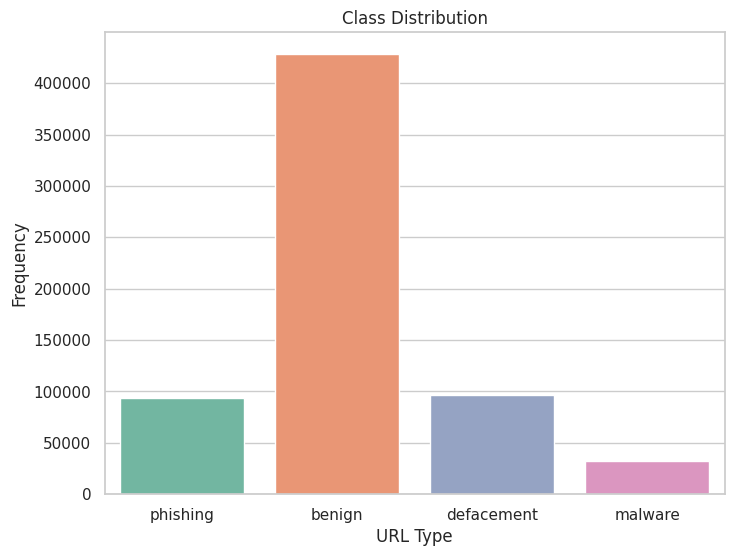

In [9]:
# Set style for seaborn
sns.set(style='whitegrid')

# 1. Distribusi Kelas
# Visualisasi distribusi kelas pada dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='type', palette='Set2')
plt.title("Class Distribution")
plt.xlabel("URL Type")
plt.ylabel("Frequency")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/All_Class_Distribution_Histogram.png')

plt.show()

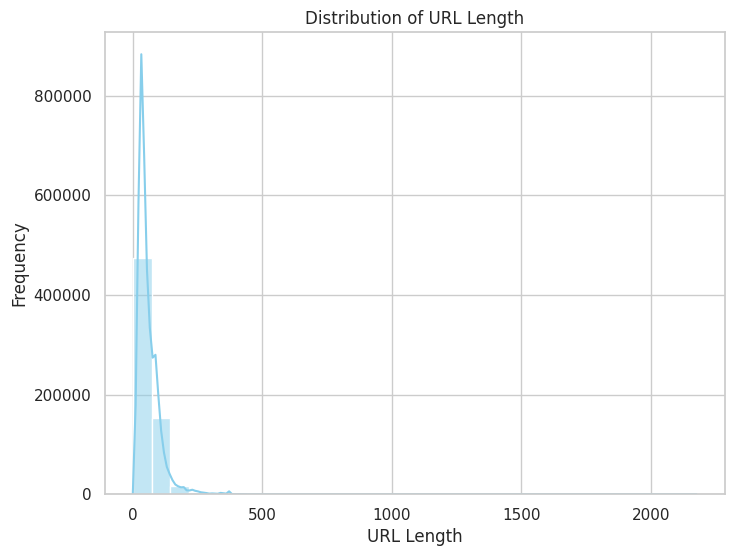

In [10]:
# 2. Distribusi Panjang URL
# Tambahkan kolom panjang URL
data['url_length'] = data['url'].apply(len)

# Visualisasi distribusi panjang URL
plt.figure(figsize=(8, 6))
sns.histplot(data['url_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of URL Length")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Distribution_of_URL_Length.png')
plt.show()

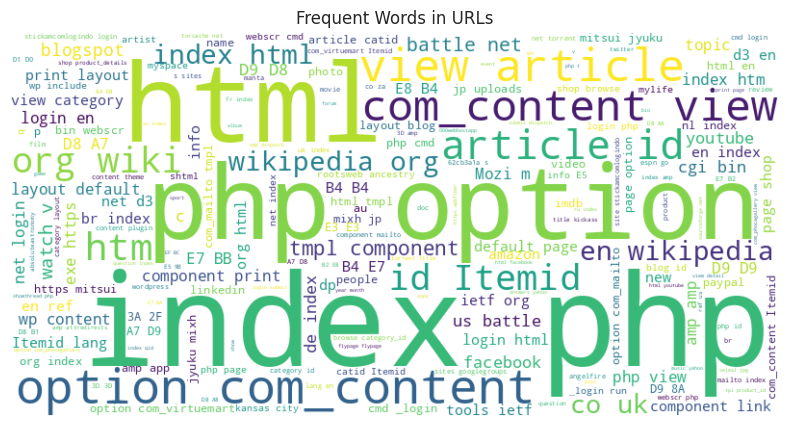

In [11]:
from wordcloud import WordCloud

# 3. Frekuensi Kata Penting
# Gabungkan semua URL dalam satu string
urls_text = ' '.join(data['url'])

# Generate word cloud dari kata-kata umum dalam URL
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(urls_text)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in URLs")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/result/Frequent_word_in_URL.png')
plt.show()



<ipython-input-12-de37b1c9b2d6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_domains.values, y=top_domains.index, palette='viridis')


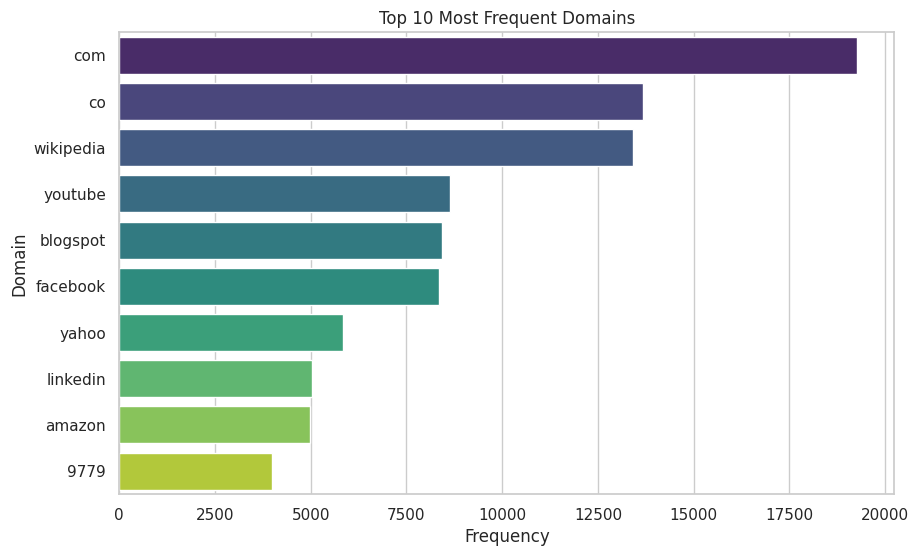

In [12]:
# Ekstraksi domain utama dari URL dengan penanganan error
def extract_domain(url):
    try:
        # Mengambil bagian domain dari URL
        parts = url.split('//')[-1].split('/')[0].split('.')
        if len(parts) >= 2:
            return parts[-2]
        else:
            return parts[0]  # Jika hanya ada satu bagian, gunakan itu
    except IndexError:
        return None  # Kembalikan None jika terjadi error

# Terapkan fungsi pada kolom URL untuk mendapatkan domain utama
data['domain'] = data['url'].apply(extract_domain)

# Visualisasikan 10 domain yang paling sering muncul
top_domains = data['domain'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_domains.values, y=top_domains.index, palette='viridis')
plt.title("Top 10 Most Frequent Domains")
plt.xlabel("Frequency")
plt.ylabel("Domain")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/10_Most_Frequent_Domains.png')
plt.show()


# **URL Cleaning**

In [ ]:
import re

# 1. Normalisasi URL: Konversi semua URL menjadi huruf kecil
data['cleaned_url'] = data['url'].str.lower()

# 2. Penghapusan Parameter Tak Relevan
# Hapus parameter setelah `?` atau `#`
data['cleaned_url'] = data['cleaned_url'].apply(lambda x: re.sub(r'\?.*|#.*', '', x))

# 3. Penghapusan Tanda Khusus yang Tidak Diperlukan
# Bersihkan elemen seperti `http://`, `https://`, dan `www.`
data['cleaned_url'] = data['cleaned_url'].apply(lambda x: re.sub(r'http://|https://|www\.', '', x))

# 4. Tokenisasi URL
# Pisahkan URL menjadi token berbasis tanda pemisah `/`, `.`, dan `-`
data['tokenized_url'] = data['cleaned_url'].apply(lambda x: re.split(r'[./\-]', x))

# Hapus token kosong akibat pemisahan karakter khusus
data['tokenized_url'] = data['tokenized_url'].apply(lambda x: [token for token in x if token])

# Tampilkan beberapa contoh hasil cleaning
print("Contoh URL Asli dan URL Setelah Cleaning:")
print(data[['url', 'cleaned_url', 'tokenized_url']].head())

# Simpan dataset yang sudah dibersihkan ke dalam file baru jika diperlukan
data.to_csv('malicious_phish_cleaned.csv', index=False)

Contoh URL Asli dan URL Setelah Cleaning:
                                                 url  \
0                                   br-icloud.com.br   
1                mp3raid.com/music/krizz_kaliko.html   
2                    bopsecrets.org/rexroth/cr/1.htm   
3  http://www.garage-pirenne.be/index.php?option=...   
4  http://adventure-nicaragua.net/index.php?optio...   

                           cleaned_url  \
0                     br-icloud.com.br   
1  mp3raid.com/music/krizz_kaliko.html   
2      bopsecrets.org/rexroth/cr/1.htm   
3          garage-pirenne.be/index.php   
4    adventure-nicaragua.net/index.php   

                               tokenized_url  
0                      [br, icloud, com, br]  
1  [mp3raid, com, music, krizz_kaliko, html]  
2     [bopsecrets, org, rexroth, cr, 1, htm]  
3          [garage, pirenne, be, index, php]  
4    [adventure, nicaragua, net, index, php]  


# **DATA SPLITTING**

Jumlah data filtered: 522214
Jumlah data trim: 2611


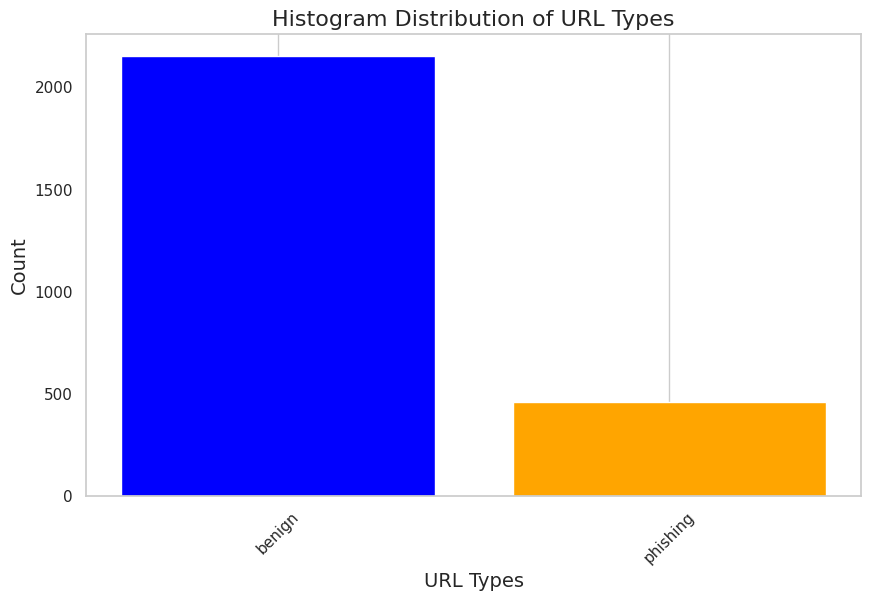

Ukuran set pelatihan: 2088
Ukuran set pengujian: 523


In [13]:
# Filter the data to keep only benign and phishing types
data_filtered = data[data['type'].isin(['benign', 'phishing'])]
print("Jumlah data filtered:", len(data_filtered))

data_filtered = data_filtered.sample(frac=0.005, random_state=42).reset_index(drop=True)
print("Jumlah data trim:", len(data_filtered))

# Hitung distribusi semua label
label_counts = data_filtered['type'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange'])
plt.xlabel('URL Types', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram Distribution of URL Types', fontsize=16)
plt.xticks(rotation=45)
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/histogram_distribution_url_type.png')
plt.grid(axis='y')

# Simpan plot
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/Histogram_distribution_datasplit.png')
plt.show()

# Define features and labels
X_multi = data_filtered['url']  # Fitur: URL
y_multi = data_filtered['type'].map({'benign': 0, 'phishing': 1})  # Mengonversi label ke numerik

# Membagi data menjadi set pelatihan (70%) dan set pengujian (30%)
X_train, X_test_bin, y_train, y_test_bin = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Menampilkan informasi tentang ukuran set
print(f'Ukuran set pelatihan: {X_train.shape[0]}')
print(f'Ukuran set pengujian: {X_test_bin.shape[0]}')


# **Data Balancing with SMOTE**

Ukuran set pelatihan sebelum SMOTE: 2088
Ukuran set pengujian: 523
Distribusi kelas sebelum SMOTE: Counter({0: 1724, 1: 364})


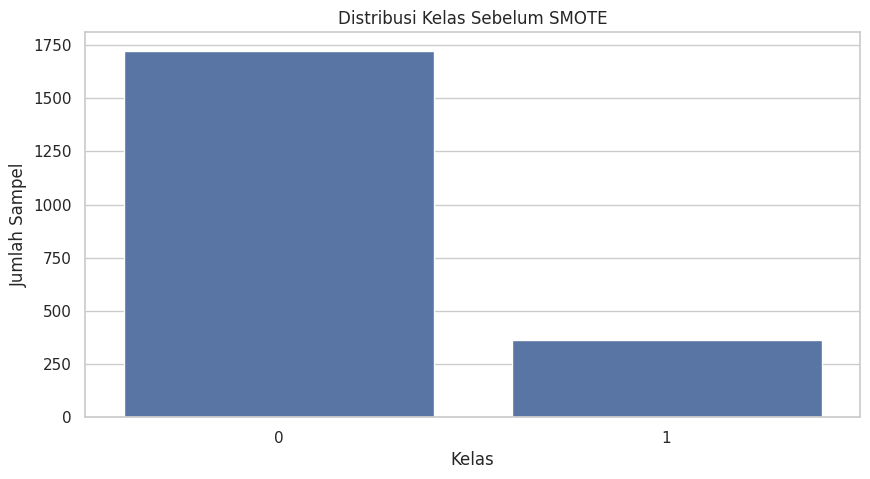

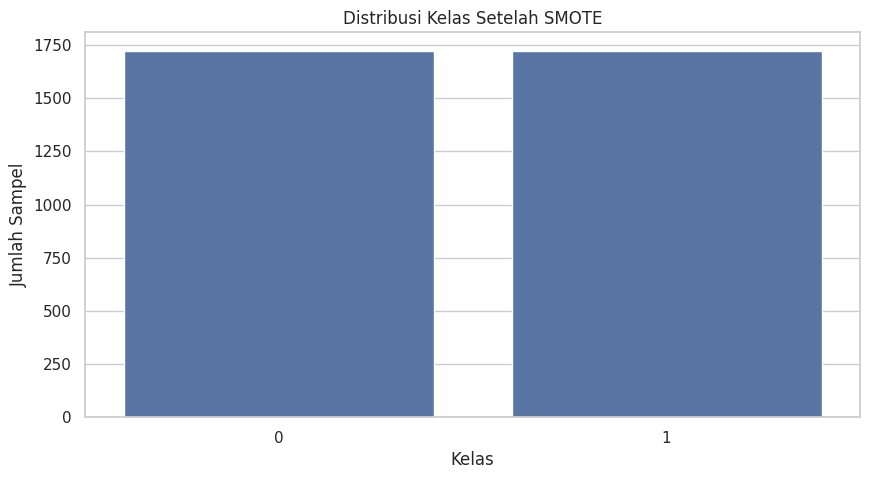

Ukuran set pelatihan setelah SMOTE: 3448
Distribusi kelas setelah SMOTE: Counter({0: 1724, 1: 1724})


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan ukuran set sebelum SMOTE
print(f'Ukuran set pelatihan sebelum SMOTE: {X_train.shape[0]}')
print(f'Ukuran set pengujian: {X_test_bin.shape[0]}')

# Menampilkan distribusi kelas sebelum SMOTE
print(f'Distribusi kelas sebelum SMOTE: {Counter(y_train)}')

# Visualisasi distribusi kelas sebelum SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title("Distribusi Kelas Sebelum SMOTE")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/histogram_distribution_url_type_before_SMOTE.png')
plt.show()

# Step 1: Convert URLs to numeric features using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Step 2: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# Visualisasi distribusi kelas setelah SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_balanced)
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/plot/histogram_distribution_url_type_after_SMOTE.png')
plt.show()

# Menampilkan ukuran set setelah SMOTE
print(f'Ukuran set pelatihan setelah SMOTE: {X_train_balanced.shape[0]}')
print(f'Distribusi kelas setelah SMOTE: {Counter(y_train_balanced)}')


#2. TRANSFORMER "BERT"**

# **CLASSIFICATION Non-Tuning**

## tes0

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.cuda.amp import GradScaler, autocast

# # Initialize GradScaler
# scaler = torch.amp.GradScaler()

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)  # random_state untuk hasil yang konsisten

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # 2. Initialize BERT tokenizer with clean_up_tokenization_spaces set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []  # List to store average train losses for plotting
# average_val_accuracies = []  # List to store validation accuracies for plotting

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization and tensor creation
#     train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#     val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Train the model
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

#             with torch.amp.autocast(device_type=device):
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to(device)
#             val_attention_mask = val_encodings['attention_mask'].to(device)
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         val_accuracies.append(accuracy)

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results for the current fold
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store average loss and accuracy for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix for the current fold
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

# # 4. Average Metrics Across All Folds
# print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
# print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# # 5. Plot the Average Confusion Matrix
# average_conf_matrix = np.mean(conf_matrix_list, axis=0)

# plt.figure(figsize=(8, 6))
# sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#             xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Average Confusion Matrix Across Folds')
# plt.show()

# # 6. Analysis of Results
# print("Hasil Deteksi Pola Enkripsi Ransomware:")
# for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
#     print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# # 7. Plot Loss and Accuracy for Each Fold
# for fold in range(len(average_train_losses)):
#     plt.figure(figsize=(12, 5))

#     # Grafik Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
#     plt.title(f'Training Loss for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Grafik Akurasi
#     plt.subplot(1, 2, 2)
#     plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
#     plt.title(f'Validation Accuracy for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

#     plt.tight_layout()
#     plt.show()


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch.amp import GradScaler, autocast
# from torch.optim import AdamW  # Using PyTorch's AdamW instead of transformers.optimization

# # Initialize gradient scaler with updated syntax
# scaler = GradScaler('cuda')

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')
# data = data.sample(frac=0.25, random_state=1)

# # Separate features and labels
# X = data['url']
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})

# # 2. Initialize BERT Tokenizer with clean_up_tokenization_spaces explicitly set
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=50)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []
# average_val_accuracies = []

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenization with explicit padding and truncation settings
#     train_encodings = tokenizer(
#         list(X_train),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )
#     val_encodings = tokenizer(
#         list(X_val),
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

#     # Initialize BERT model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y.unique()),
#         problem_type="single_label_classification"
#     )
#     model.to(device)

#     # Initialize optimizer using PyTorch's AdamW (removed no_deprecation_warning parameter)
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#        # Training loop
#     num_epochs = 3
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         batch_count = 0

#         for batch in train_loader:
#             # Clear gradients at the start of each batch
#             optimizer.zero_grad(set_to_none=True)

#             try:
#                 # Move batch to device and handle potential CUDA out of memory
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 # Forward pass with gradient scaling
#                 with autocast(device_type='cuda', dtype=torch.float16):
#                     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                     loss = outputs.loss

#                 # Backward pass with gradient scaling
#                 scaler.scale(loss).backward()

#                 # Optimize and update scaler
#                 scaler.unscale_(optimizer)
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 scaler.step(optimizer)
#                 scaler.update()

#                 # Accumulate loss
#                 current_loss = loss.item()
#                 epoch_loss += current_loss
#                 batch_count += 1

#                 # Print progress every 10 batches
#                 if batch_count % 10 == 0:
#                     print(f'Epoch {epoch+1}, Batch {batch_count}, Loss: {current_loss:.4f}')

#                 # Clear memory
#                 del outputs, loss
#                 torch.cuda.empty_cache()

#             except RuntimeError as e:
#                 if "out of memory" in str(e):
#                     print('| WARNING: ran out of memory, skipping batch')
#                     if torch.cuda.is_available():
#                         torch.cuda.empty_cache()
#                     continue
#                 else:
#                     raise e

#         # Calculate average loss for the epoch
#         avg_loss = epoch_loss / max(batch_count, 1)  # Prevent division by zero
#         train_losses.append(avg_loss)
#         print(f'Epoch {epoch+1} completed, Average Loss: {avg_loss:.4f}')

#         # Validation step
#         model.eval()
#         val_predictions = []
#         val_labels = []

#         with torch.no_grad():
#             # Process validation data in smaller chunks
#             batch_size = 32  # Smaller batch size for validation
#             for i in range(0, len(val_encodings['input_ids']), batch_size):
#                 batch_end = min(i + batch_size, len(val_encodings['input_ids']))
#                 val_batch_input_ids = val_encodings['input_ids'][i:batch_end].to(device)
#                 val_batch_attention_mask = val_encodings['attention_mask'][i:batch_end].to(device)

#                 outputs = model(val_batch_input_ids, attention_mask=val_batch_attention_mask)
#                 batch_predictions = torch.argmax(outputs.logits, dim=1)

#                 val_predictions.extend(batch_predictions.cpu().numpy())

#                 # Clear memory
#                 del outputs, batch_predictions
#                 torch.cuda.empty_cache()

#         # Calculate accuracy
#         accuracy = accuracy_score(y_val, val_predictions)
#         val_accuracies.append(accuracy)
#         print(f'Validation Accuracy: {accuracy:.4f}')

#         # Model saving and early stopping
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(),
#                                     target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store metrics for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'],
#                 yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()



## 4d


Fold 1/5


Fold 1 - Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5158, Val Loss = 0.3180, Accuracy = 88.26%, F1 Score = 0.8823, AUC-ROC = 0.9307
Saved best model for fold 1 at epoch 1.


Epoch 2 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.2960, Val Loss = 0.2640, Accuracy = 89.86%, F1 Score = 0.8981, AUC-ROC = 0.9493
Saved best model for fold 1 at epoch 2.


Epoch 3 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2412, Val Loss = 0.2304, Accuracy = 91.59%, F1 Score = 0.9158, AUC-ROC = 0.9636
Saved best model for fold 1 at epoch 3.


Epoch 4 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.2063, Val Loss = 0.2201, Accuracy = 92.46%, F1 Score = 0.9246, AUC-ROC = 0.9712
Saved best model for fold 1 at epoch 4.


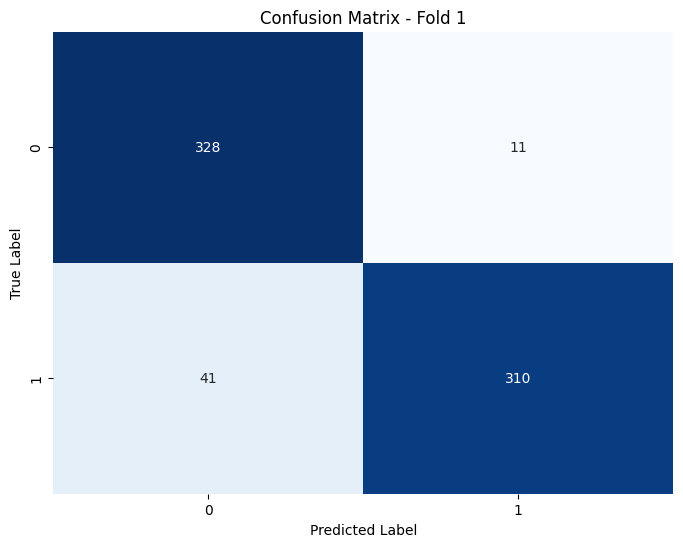


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       339
           1       0.97      0.88      0.92       351

    accuracy                           0.92       690
   macro avg       0.93      0.93      0.92       690
weighted avg       0.93      0.92      0.92       690


Fold 2/5


Fold 2 - Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.4892, Val Loss = 0.2943, Accuracy = 89.71%, F1 Score = 0.8971, AUC-ROC = 0.9361
Saved best model for fold 2 at epoch 1.


Epoch 2 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.2809, Val Loss = 0.2772, Accuracy = 88.84%, F1 Score = 0.8883, AUC-ROC = 0.9566


Epoch 3 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2254, Val Loss = 0.2193, Accuracy = 92.17%, F1 Score = 0.9215, AUC-ROC = 0.9604
Saved best model for fold 2 at epoch 3.


Epoch 4 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.1868, Val Loss = 0.2157, Accuracy = 92.03%, F1 Score = 0.9203, AUC-ROC = 0.9741


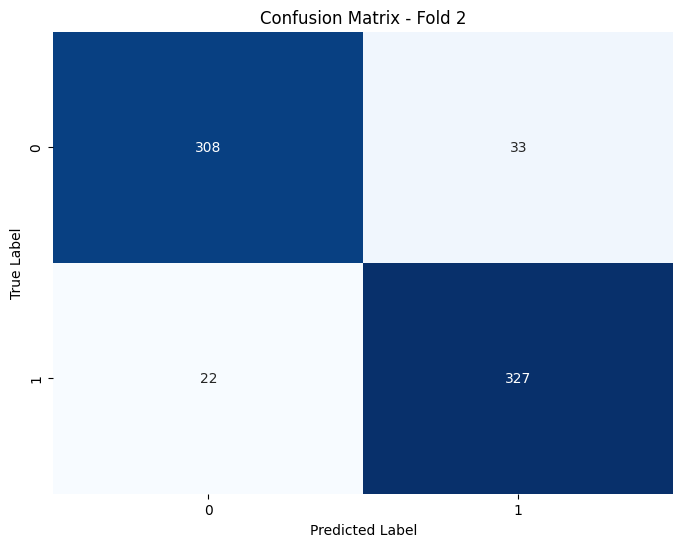


Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       341
           1       0.91      0.94      0.92       349

    accuracy                           0.92       690
   macro avg       0.92      0.92      0.92       690
weighted avg       0.92      0.92      0.92       690


Fold 3/5


Fold 3 - Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5220, Val Loss = 0.3410, Accuracy = 86.96%, F1 Score = 0.8685, AUC-ROC = 0.9138
Saved best model for fold 3 at epoch 1.


Epoch 2 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.3200, Val Loss = 0.2557, Accuracy = 90.14%, F1 Score = 0.9004, AUC-ROC = 0.9606
Saved best model for fold 3 at epoch 2.


Epoch 3 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2596, Val Loss = 0.2314, Accuracy = 91.74%, F1 Score = 0.9174, AUC-ROC = 0.9674
Saved best model for fold 3 at epoch 3.


Epoch 4 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.2160, Val Loss = 0.2158, Accuracy = 92.17%, F1 Score = 0.9217, AUC-ROC = 0.9695
Saved best model for fold 3 at epoch 4.


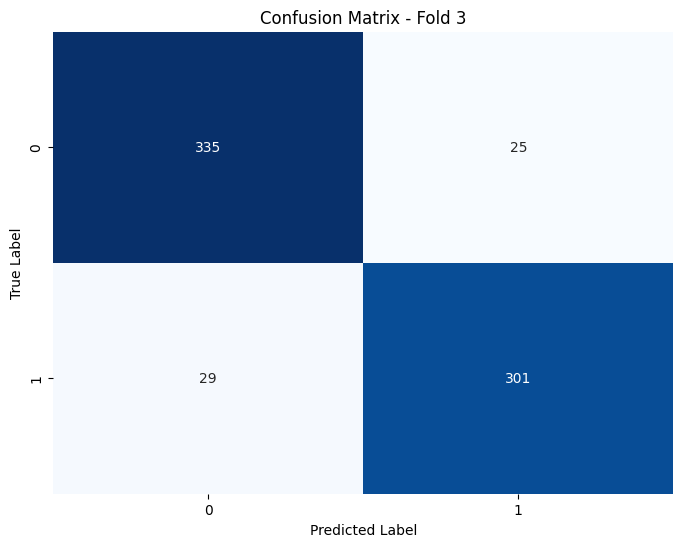


Classification Report - Fold 3
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       360
           1       0.92      0.91      0.92       330

    accuracy                           0.92       690
   macro avg       0.92      0.92      0.92       690
weighted avg       0.92      0.92      0.92       690


Fold 4/5


Fold 4 - Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5288, Val Loss = 0.4310, Accuracy = 82.44%, F1 Score = 0.8239, AUC-ROC = 0.9058
Saved best model for fold 4 at epoch 1.


Epoch 2 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.3374, Val Loss = 0.3573, Accuracy = 87.37%, F1 Score = 0.8728, AUC-ROC = 0.9368
Saved best model for fold 4 at epoch 2.


Epoch 3 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2608, Val Loss = 0.2959, Accuracy = 89.55%, F1 Score = 0.8952, AUC-ROC = 0.9440
Saved best model for fold 4 at epoch 3.


Epoch 4 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.2241, Val Loss = 0.2776, Accuracy = 90.71%, F1 Score = 0.9069, AUC-ROC = 0.9539
Saved best model for fold 4 at epoch 4.


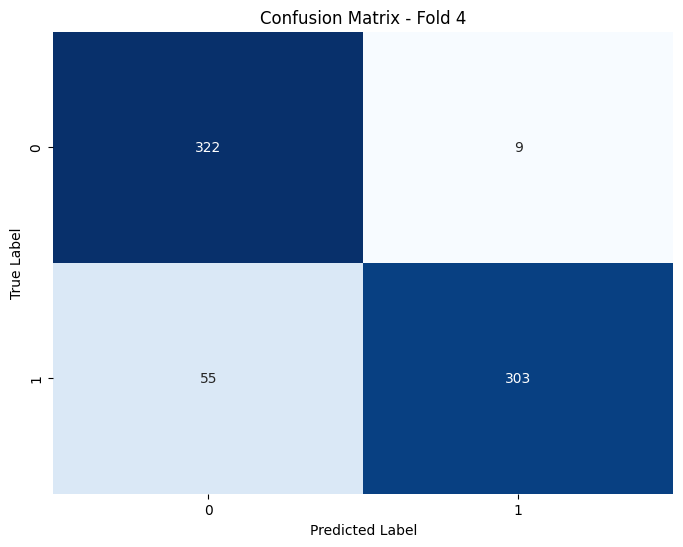


Classification Report - Fold 4
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       331
           1       0.97      0.85      0.90       358

    accuracy                           0.91       689
   macro avg       0.91      0.91      0.91       689
weighted avg       0.91      0.91      0.91       689


Fold 5/5


Fold 5 - Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.5468, Val Loss = 0.3136, Accuracy = 88.10%, F1 Score = 0.8794, AUC-ROC = 0.9432
Saved best model for fold 5 at epoch 1.


Epoch 2 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.2969, Val Loss = 0.2400, Accuracy = 91.58%, F1 Score = 0.9158, AUC-ROC = 0.9584
Saved best model for fold 5 at epoch 2.


Epoch 3 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2378, Val Loss = 0.2031, Accuracy = 93.47%, F1 Score = 0.9347, AUC-ROC = 0.9730
Saved best model for fold 5 at epoch 3.


Epoch 4 - Training:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.1993, Val Loss = 0.2103, Accuracy = 93.76%, F1 Score = 0.9376, AUC-ROC = 0.9741
Saved best model for fold 5 at epoch 4.


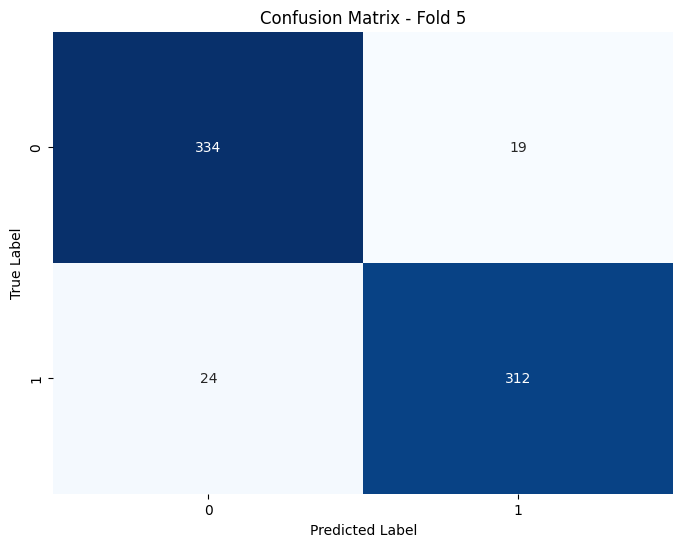


Classification Report - Fold 5
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       353
           1       0.94      0.93      0.94       336

    accuracy                           0.94       689
   macro avg       0.94      0.94      0.94       689
weighted avg       0.94      0.94      0.94       689



In [ ]:
import transformers
from torch.cuda.amp import autocast, GradScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader

# Suppress FutureWarnings globally
warnings.simplefilter("ignore", category=FutureWarning)

# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
lr = 1e-5 #5e-5
k_folds = 5
num_epochs = 4

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

def plot_confusion_matrix(y_true, y_pred, fold):
    """
    Plot and display confusion matrix for the current fold
    """
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))

    # Add labels and title
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Save and show the plot
    plt.savefig(f'confusion_matrix_fold_{fold}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Print classification report
    print(f"\nClassification Report - Fold {fold}")
    print(classification_report(y_true, y_pred))

def tokenize_data(texts, tokenizer):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='longest',
        return_tensors='pt',
        max_length=128
    )
    # print(f"Input IDs shape: {encodings['input_ids'].shape}")
    # print(f"Attention Mask shape: {encodings['attention_mask'].shape}")
    return encodings

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    val_probs = []  # Tambahkan list untuk menyimpan probabilitas prediksi
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            batch_probs = torch.softmax(outputs.logits, dim=1)  # Hitung probabilitas dengan softmax
            batch_predictions = torch.argmax(outputs.logits, dim=1)

            val_predictions.extend(batch_predictions.cpu().numpy())
            val_probs.extend(batch_probs.cpu().numpy())  # Simpan probabilitas

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions, val_probs  # Tambahkan val_probs untuk AUC-ROC

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(y_val.unique()),
        problem_type="single_label_classification"
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    for epoch in tqdm(range(num_epochs), desc=f'Fold {fold} - Epoch', leave=False):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} - Training', leave=False):
            optimizer.zero_grad(set_to_none=True)
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with autocast(enabled=torch.cuda.is_available(), dtype=torch.float16):


                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_loader)

        # Panggil compute_validation_metrics dan tangkap val_probs untuk AUC-ROC
        val_loss, accuracy, f1, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

        # Hitung AUC-ROC untuk setiap epoch
        if len(np.unique(y_val)) == 2:
            # Jika hanya dua kelas, ambil probabilitas kelas positif
            epoch_roc_auc = roc_auc_score(y_val, [prob[1] for prob in val_probs])
        else:
            # Untuk multi-kelas
            epoch_roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy*100:.2f}%, F1 Score = {f1:.4f}, AUC-ROC = {epoch_roc_auc:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model.save_pretrained(f'model_best_fold_{fold}')
            print(f"Saved best model for fold {fold} at epoch {epoch+1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs


# Metrics collection
all_labels = []  # Ubah ke list kosong
all_probs = []   # Ubah ke list kosong
all_preds = []
fold_results = []

# Main KFold loop with updates
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# Main KFold loop with validation dataset creation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_balanced), 1):
    print(f"\nFold {fold}/{k_folds}")

    # Slicing the data
    X_train, X_val = X_train_balanced[train_index], X_train_balanced[val_index]
    y_train, y_val = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]

    # print(f"X_train shape: {X_train.shape}")
    # print(f"X_val shape: {X_val.shape}")
    # print(f"y_train shape: {y_train.shape}")
    # print(f"y_val shape: {y_val.shape}")

    # Convert sparse matrix to dense and then to a list of strings
    train_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_train]
    val_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_val]

    # print(f"Number of train texts: {len(train_texts)}")
    # print(f"Number of val texts: {len(val_texts)}")

    # Tokenize both training and validation data
    train_encodings = tokenize_data(train_texts, tokenizer)
    val_encodings = tokenize_data(val_texts, tokenizer)

    # Convert labels to tensors
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    # print(f"y_train_tensor shape: {y_train_tensor.shape}")
    # print(f"y_val_tensor shape: {y_val_tensor.shape}")

    # Create both training and validation datasets
    try:
        train_dataset = TensorDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            y_train_tensor
        )
        # print(f"Successfully created train_dataset with size: {len(train_dataset)}")

        val_dataset = TensorDataset(
            val_encodings['input_ids'],
            val_encodings['attention_mask'],
            y_val_tensor
        )
        # print(f"Successfully created val_dataset with size: {len(val_dataset)}")

    except AssertionError as e:
        print("Error creating datasets:")
        print(f"Train Input IDs size: {train_encodings['input_ids'].size()}")
        print(f"Train Attention Mask size: {train_encodings['attention_mask'].size()}")
        print(f"Train Labels size: {y_train_tensor.size()}")
        print(f"Val Input IDs size: {val_encodings['input_ids'].size()}")
        print(f"Val Attention Mask size: {val_encodings['attention_mask'].size()}")
        print(f"Val Labels size: {y_val_tensor.size()}")
        raise e

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Train and evaluate for the current fold
    avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    # Plot confusion matrix and print classification report for this fold
    plot_confusion_matrix(y_val, val_predictions, fold)

    # Collect predictions and true labels
    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)
    all_probs.extend(val_probs)  # Simpan probabilitas untuk AUC-ROC


In [ ]:
# Jika hanya ada dua kelas, pastikan bentuk probabilitas cocok
if len(np.unique(all_labels)) == 2:
    # Ambil probabilitas untuk kelas positif (kelas 1)
    all_probs = np.array([prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, all_probs)
else:
    # Untuk multi-kelas, biarkan all_probs dalam bentuk asli
    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Average AUC-ROC Across All Folds: {roc_auc:.4f}")

Average AUC-ROC Across All Folds: 0.9649


Average Metrics Across Folds:
Train loss: 0.2065
Val loss: 0.2279
Accuracy: 0.9223
F1 score: 0.9222
Auc roc: 0.9649


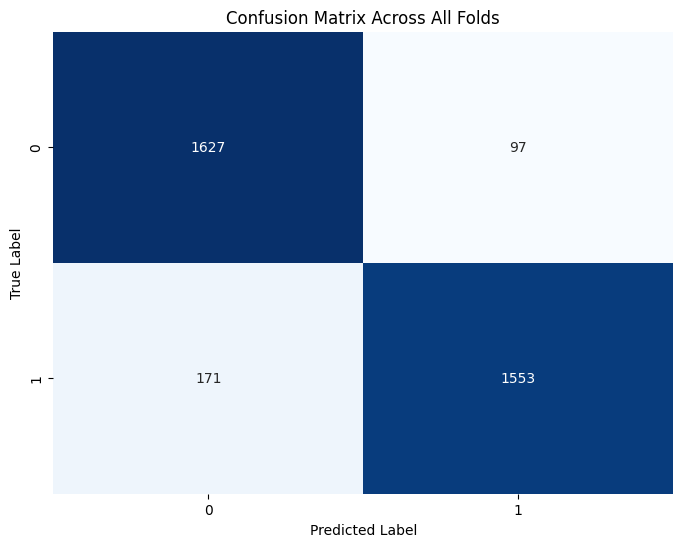


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.9049    0.9437    0.9239      1724
           1     0.9412    0.9008    0.9206      1724

    accuracy                         0.9223      3448
   macro avg     0.9231    0.9223    0.9222      3448
weighted avg     0.9231    0.9223    0.9222      3448



In [ ]:
# Average Metrics Across Folds
avg_metrics = {
    key: np.mean([result[idx] for result in fold_results])
    for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
}
avg_metrics['auc_roc'] = roc_auc  # Tambahkan AUC-ROC rata-rata

print("Average Metrics Across Folds:")
for key, value in avg_metrics.items():
    print(f"{key.replace('_', ' ').capitalize()}: {value:.4f}")

# Calculate and plot the overall confusion matrix after all folds
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(all_labels, all_preds, digits=4)
print("\nClassification Report for All Folds:")
print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)


# **Hyperparameter Tuning**

## tes0

In [ ]:
# !pip install optuna


In [ ]:
# import pandas as pd
# import numpy as np
# import optuna
# import torch
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import KFold
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from torch.utils.data import DataLoader, TensorDataset

# # Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # Inisialisasi Tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# def train_model(trial):
#     # Hyperparameter tuning
#     batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
#     num_epochs = trial.suggest_int('num_epochs', 3, 10)

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     all_accuracy = []

#     for train_index, val_index in kf.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         # Tokenisasi dan pembuatan tensor
#         train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#         val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#         # Convert labels to tensors
#         y_train_tensor = torch.LongTensor(y_train.values)
#         y_val_tensor = torch.LongTensor(y_val.values)

#         # Create DataLoader
#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#         # Initialize BERT model
#         model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#         model.to('cuda' if torch.cuda.is_available() else 'cpu')
#         optimizer = AdamW(model.parameters(), lr=learning_rate, )

#         # Train the model
#         for epoch in range(num_epochs):
#             model.train()
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = batch
#                 input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to('cuda')
#             val_attention_mask = val_encodings['attention_mask'].to('cuda')
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         all_accuracy.append(accuracy)

#     # Return average accuracy across folds
#     return np.mean(all_accuracy)

# # Create a study object for hyperparameter optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(train_model, n_trials=20)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)
# print("Best accuracy: ", study.best_value)


In [ ]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# from sklearn.model_selection import KFold, ParameterGrid
# from sklearn.metrics import accuracy_score, f1_score
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm
# import transformers

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 4  # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val, val_predictions)
#     f1 = f1_score(y_val, val_predictions, average='weighted')
#     return avg_val_loss, accuracy, f1, val_predictions

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     best_val_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         # Progress bar for training
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss

#                 loss.backward()
#                 optimizer.step()
#                 total_train_loss += loss.item()

#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, _ = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
#               f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}")

#     return best_val_loss

# # Hyperparameter grid
# param_grid = {
#     'batch_size': [32, 64],
#     'd_model': [128, 256],
#     'dropout': [0.1, 0.2],
#     'lr': [0.001, 0.0001],
#     'nhead': [4, 8]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Iterate through all combinations of parameters
# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_bin), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_bin.iloc[train_index], X_train_bin.iloc[val_index]
#         y_train, y_val = y_train_bin.iloc[train_index], y_train_bin.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss = train_and_evaluate(fold, train_loader, val_loader, y_val, params['batch_size'], params['lr'])

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")


## tes3

In [ ]:
# import transformers
# from transformers import get_linear_schedule_with_warmup

# # Set transformers logging to error only
# transformers.logging.set_verbosity_error()

# # Constants
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_epochs = 4 # Set to 4 as per your output example

# # Load tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# def tokenize_data(texts):
#     return tokenizer(
#         texts,
#         truncation=True,
#         padding=True,
#         return_tensors='pt',
#         max_length=512
#     )

# def compute_validation_metrics(model, val_loader, y_val):
#     model.eval()
#     val_predictions = []
#     val_probs = []
#     total_val_loss = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids, attention_mask, labels = [b.to(device) for b in batch]
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             total_val_loss += loss.item()
#             batch_probs = torch.softmax(outputs.logits, dim=1)
#             batch_predictions = torch.argmax(outputs.logits, dim=1)
#             val_predictions.extend(batch_predictions.cpu().numpy())
#             val_probs.extend(batch_probs.cpu().numpy())

#     avg_val_loss = total_val_loss / len(val_loader)
#     accuracy = accuracy_score(y_val.cpu(), val_predictions)
#     f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')

#     # Compute AUC-ROC
#     if len(set(y_val.cpu().numpy())) == 2:
#         auc_roc = roc_auc_score(y_val.cpu(), [p[1] for p in val_probs])
#     else:
#         auc_roc = roc_auc_score(y_val.cpu(), val_probs, multi_class='ovr')

#     return avg_val_loss, accuracy, f1, auc_roc

# def train_and_evaluate(fold, train_loader, val_loader, y_val, batch_size, lr):
#     model = BertForSequenceClassification.from_pretrained(
#         'bert-base-uncased',
#         num_labels=len(y_val.unique()),
#         problem_type="single_label_classification"
#     ).to(device)

#     optimizer = AdamW(model.parameters(), lr=lr)
#     # Menambahkan Scheduler dengan warm-up steps
#     total_steps = len(train_loader) * num_epochs
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#     best_val_loss = float('inf')
#     best_accuracy = 0.0
#     best_auc_roc = 0.0
#     best_model_state = None
#     patience = 2  # Early stopping patience
#     patience_counter = 0

#     for epoch in range(num_epochs):
#         model.train()
#         total_train_loss = 0
#         with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', leave=False) as pbar:
#             for batch in train_loader:
#                 optimizer.zero_grad()
#                 input_ids, attention_mask, labels = [b.to(device) for b in batch]

#                 outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#                 loss = outputs.loss
#                 loss.backward()
#                 optimizer.step()
#                 scheduler.step()  # Update learning rate

#                 total_train_loss += loss.item()
#                 pbar.set_postfix(loss=loss.item())
#                 pbar.update(1)

#         avg_train_loss = total_train_loss / len(train_loader)
#         val_loss, accuracy, f1, auc_roc = compute_validation_metrics(model, val_loader, y_val)

#         print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}, "
#               f"Validation Loss = {val_loss:.4f}, Accuracy = {accuracy * 100:.2f}%, "
#               f"F1 Score = {f1:.4f}, AUC-ROC = {auc_roc:.4f}")

#         # Update best model berdasarkan accuracy dan AUC-ROC dengan early stopping
#         if accuracy > best_accuracy or (accuracy == best_accuracy and auc_roc > best_auc_roc):
#             best_val_loss = val_loss
#             best_accuracy = accuracy
#             best_auc_roc = auc_roc
#             best_model_state = model.state_dict()
#             patience_counter = 0  # Reset counter saat improvement ditemukan
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#     model.load_state_dict(best_model_state)
#     return best_val_loss, accuracy, f1, best_auc_roc


# # Hyperparameter grid
# param_grid = {
#     'nhead': [2, 4, 8],
#     'd_model': [256, 512, 768],
#     'dropout': [0.1],
#     'lr': [1e-5, 3e-5, 5e-5],
#     'batch_size': [32]
# }

# # Metrics collection
# best_hyperparams = None
# best_val_loss = float('inf')
# best_accuracy = 0.0
# best_auc_roc = 0.0

# # Main KFold loop
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for params in ParameterGrid(param_grid):
#     print(f"Evaluating params: {params}")

#     for fold, (train_index, val_index) in enumerate(kf.split(X_train_balanced), 1):
#         print(f"Fold {fold}/5")
#         X_train, X_val = X_train_balanced.iloc[train_index], X_train_balanced.iloc[val_index]
#         y_train, y_val = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]

#         train_encodings = tokenize_data(list(X_train))
#         val_encodings = tokenize_data(list(X_val))

#         y_train_tensor = torch.LongTensor(y_train.values).to(device)
#         y_val_tensor = torch.LongTensor(y_val.values).to(device)

#         train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#         val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], y_val_tensor)

#         train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#         val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

#         val_loss, accuracy, f1, auc_roc = train_and_evaluate(fold, train_loader, val_loader, y_val_tensor, params['batch_size'], params['lr'])

#         # Memprioritaskan akurasi untuk pemilihan parameter terbaik
#         if accuracy > best_accuracy or (accuracy == best_accuracy and auc_roc > best_auc_roc):
#             best_val_loss = val_loss
#             best_accuracy = accuracy  # Update best accuracy
#             best_auc_roc = auc_roc
#             best_hyperparams = params

# print("\nBest Hyperparameters:")
# print(f"Parameters: {best_hyperparams}")
# print(f"Best Average Validation Loss: {best_val_loss:.4f}")
# print(f"Best Average Accuracy: {best_accuracy * 100:.2f}%")
# print(f"Best Average AUC-ROC: {best_auc_roc:.4f}")


Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 2}
Fold 1/5


AttributeError: 'csr_matrix' object has no attribute 'iloc'

## tes4

In [ ]:
import transformers
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np

# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 4

class BERTHyperparameterTuning:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)
        transformers.logging.set_verbosity_error()

    def tokenize_data(self, texts):
        return self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            return_tensors='pt',
            max_length=512
        )

    def compute_validation_metrics(self, model, val_loader, y_val):
        model.eval()
        val_predictions = []
        val_probs = []
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()

                probs = torch.softmax(outputs.logits, dim=1)
                predictions = torch.argmax(outputs.logits, dim=1)

                val_predictions.extend(predictions.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(y_val.cpu(), val_predictions)
        f1 = f1_score(y_val.cpu(), val_predictions, average='weighted')

        # Compute AUC-ROC
        if len(set(y_val.cpu().numpy())) == 2:
            auc_roc = roc_auc_score(y_val.cpu(), [p[1] for p in val_probs])
        else:
            auc_roc = roc_auc_score(y_val.cpu(), val_probs, multi_class='ovr')

        return avg_val_loss, accuracy, f1, auc_roc

    def train_and_evaluate(self, fold, train_loader, val_loader, y_val, params):
        model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=len(torch.unique(y_val)),
            problem_type="single_label_classification"
        ).to(device)

        optimizer = AdamW(model.parameters(), lr=params['lr'])

        # Scheduler with warm-up steps
        total_steps = len(train_loader) * num_epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        best_val_loss = float('inf')
        best_accuracy = 0.0
        best_auc_roc = 0.0
        best_model_state = None
        patience = 2
        patience_counter = 0

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0

            with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False) as pbar:
                for batch in train_loader:
                    optimizer.zero_grad()
                    input_ids, attention_mask, labels = [b.to(device) for b in batch]

                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

                    total_train_loss += loss.item()
                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            avg_train_loss = total_train_loss / len(train_loader)
            val_loss, accuracy, f1, auc_roc = self.compute_validation_metrics(
                model, val_loader, y_val
            )

            print(f"Epoch {epoch + 1}/{num_epochs}: "
                  f"Train Loss = {avg_train_loss:.4f}, "
                  f"Val Loss = {val_loss:.4f}, "
                  f"Accuracy = {accuracy * 100:.2f}%, "
                  f"F1 = {f1:.4f}, "
                  f"AUC-ROC = {auc_roc:.4f}")

            if accuracy > best_accuracy or (accuracy == best_accuracy and auc_roc > best_auc_roc):
                best_val_loss = val_loss
                best_accuracy = accuracy
                best_auc_roc = auc_roc
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        model.load_state_dict(best_model_state)
        return best_val_loss, best_accuracy, f1, best_auc_roc

    def find_best_hyperparameters(self, X_train_balanced, y_train_balanced):
        param_grid = {
            'nhead': [2, 4, 8],
            'd_model': [256, 512, 768],
            'dropout': [0.1],
            'lr': [1e-5, 3e-5, 5e-5],
            'batch_size': [32]
        }

        best_hyperparams = None
        best_val_loss = float('inf')
        best_accuracy = 0.0
        best_auc_roc = 0.0

        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        for params in ParameterGrid(param_grid):
            print(f"\nEvaluating params: {params}")
            fold_metrics = []

            # Untuk sparse matrix, gunakan metode yang benar untuk splitting
            for fold, (train_index, val_index) in enumerate(kf.split(X_train_balanced), 1):
                print(f"Fold {fold}/5")

                # Gunakan array indexing untuk sparse matrix
                X_train = X_train_balanced[train_index]
                X_val = X_train_balanced[val_index]
                y_train = y_train_balanced[train_index]
                y_val = y_train_balanced[val_index]

                # Convert sparse matrix to text format
                train_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_train]
                val_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_val]

                # Tokenize
                train_encodings = self.tokenize_data(train_texts)
                val_encodings = self.tokenize_data(val_texts)

                # Convert to tensors
                y_train_tensor = torch.LongTensor(y_train.values if isinstance(y_train, pd.Series) else y_train).to(device)
                y_val_tensor = torch.LongTensor(y_val.values if isinstance(y_val, pd.Series) else y_val).to(device)


                # Create datasets
                train_dataset = TensorDataset(
                    train_encodings['input_ids'],
                    train_encodings['attention_mask'],
                    y_train_tensor
                )
                val_dataset = TensorDataset(
                    val_encodings['input_ids'],
                    val_encodings['attention_mask'],
                    y_val_tensor
                )

                # Create dataloaders
                train_loader = DataLoader(
                    train_dataset,
                    batch_size=params['batch_size'],
                    shuffle=True
                )
                val_loader = DataLoader(
                    val_dataset,
                    batch_size=params['batch_size'],
                    shuffle=False
                )

                # Train and evaluate
                val_loss, accuracy, f1, auc_roc = self.train_and_evaluate(
                    fold, train_loader, val_loader, y_val_tensor, params
                )
                fold_metrics.append((val_loss, accuracy, f1, auc_roc))

            # Calculate average metrics across folds
            avg_val_loss = np.mean([m[0] for m in fold_metrics])
            avg_accuracy = np.mean([m[1] for m in fold_metrics])
            avg_auc_roc = np.mean([m[3] for m in fold_metrics])

            # Update best parameters if better performance
            if avg_accuracy > best_accuracy or (avg_accuracy == best_accuracy and avg_auc_roc > best_auc_roc):
                best_val_loss = avg_val_loss
                best_accuracy = avg_accuracy
                best_auc_roc = avg_auc_roc
                best_hyperparams = params

        return best_hyperparams, best_val_loss, best_accuracy, best_auc_roc

In [ ]:
# Inisialisasi tuner
tuner = BERTHyperparameterTuning()

# Cari hyperparameter terbaik
best_params, val_loss, accuracy, auc_roc = tuner.find_best_hyperparameters(
    X_train_balanced,
    y_train_balanced
)

print("\nHasil Terbaik:")
print(f"Parameters: {best_params}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"AUC-ROC: {auc_roc:.4f}")


Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 2}
Fold 1/5


Epoch 1/4: Train Loss = 0.6793, Val Loss = 0.5620, Accuracy = 72.22%, F1 = 0.7130, AUC-ROC = 0.8757


Epoch 2/4: Train Loss = 0.6148, Val Loss = 0.5131, Accuracy = 81.94%, F1 = 0.8193, AUC-ROC = 0.8826


Epoch 3/4: Train Loss = 0.5537, Val Loss = 0.4673, Accuracy = 84.72%, F1 = 0.8471, AUC-ROC = 0.9058


Epoch 4/4: Train Loss = 0.5347, Val Loss = 0.4490, Accuracy = 87.50%, F1 = 0.8750, AUC-ROC = 0.8981
Fold 2/5


Epoch 1/4: Train Loss = 0.6750, Val Loss = 0.6193, Accuracy = 76.06%, F1 = 0.7606, AUC-ROC = 0.8238


Epoch 2/4: Train Loss = 0.6180, Val Loss = 0.5471, Accuracy = 71.83%, F1 = 0.7120, AUC-ROC = 0.8246


Epoch 3/4: Train Loss = 0.5449, Val Loss = 0.4799, Accuracy = 73.24%, F1 = 0.7294, AUC-ROC = 0.8492
Early stopping triggered
Fold 3/5


Epoch 1/4: Train Loss = 0.6748, Val Loss = 0.5620, Accuracy = 56.34%, F1 = 0.4653, AUC-ROC = 0.9040


Epoch 2/4: Train Loss = 0.6153, Val Loss = 0.4884, Accuracy = 81.69%, F1 = 0.8162, AUC-ROC = 0.9262


Epoch 3/4: Train Loss = 0.5486, Val Loss = 0.4520, Accuracy = 78.87%, F1 = 0.7870, AUC-ROC = 0.9397


Epoch 4/4: Train Loss = 0.5219, Val Loss = 0.4469, Accuracy = 80.28%, F1 = 0.7992, AUC-ROC = 0.9413
Early stopping triggered
Fold 4/5


Epoch 1/4: Train Loss = 0.7038, Val Loss = 0.6124, Accuracy = 46.48%, F1 = 0.3318, AUC-ROC = 0.8862


Epoch 2/4: Train Loss = 0.6106, Val Loss = 0.4638, Accuracy = 84.51%, F1 = 0.8454, AUC-ROC = 0.9327


Epoch 3/4: Train Loss = 0.5190, Val Loss = 0.3942, Accuracy = 91.55%, F1 = 0.9152, AUC-ROC = 0.9471


Epoch 4/4: Train Loss = 0.4829, Val Loss = 0.3631, Accuracy = 91.55%, F1 = 0.9152, AUC-ROC = 0.9551
Fold 5/5


Epoch 1/4: Train Loss = 0.6886, Val Loss = 0.6300, Accuracy = 80.28%, F1 = 0.7972, AUC-ROC = 0.8871


Epoch 2/4: Train Loss = 0.6521, Val Loss = 0.5691, Accuracy = 81.69%, F1 = 0.8126, AUC-ROC = 0.9169


Epoch 3/4: Train Loss = 0.5824, Val Loss = 0.5194, Accuracy = 83.10%, F1 = 0.8310, AUC-ROC = 0.8968


Epoch 4/4: Train Loss = 0.5561, Val Loss = 0.4966, Accuracy = 81.69%, F1 = 0.8156, AUC-ROC = 0.9032

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 4}
Fold 1/5


Epoch 1/4: Train Loss = 0.6767, Val Loss = 0.5475, Accuracy = 70.83%, F1 = 0.6891, AUC-ROC = 0.9205


Epoch 2/4: Train Loss = 0.5905, Val Loss = 0.4995, Accuracy = 87.50%, F1 = 0.8749, AUC-ROC = 0.9174


Epoch 3/4: Train Loss = 0.5403, Val Loss = 0.4349, Accuracy = 90.28%, F1 = 0.9025, AUC-ROC = 0.9529


Epoch 4/4: Train Loss = 0.5073, Val Loss = 0.4145, Accuracy = 83.33%, F1 = 0.8326, AUC-ROC = 0.9622
Fold 2/5


Epoch 1/4: Train Loss = 0.6688, Val Loss = 0.6030, Accuracy = 54.93%, F1 = 0.4759, AUC-ROC = 0.7802


Epoch 2/4: Train Loss = 0.6145, Val Loss = 0.5346, Accuracy = 71.83%, F1 = 0.7159, AUC-ROC = 0.8230


Epoch 3/4: Train Loss = 0.5426, Val Loss = 0.5018, Accuracy = 70.42%, F1 = 0.7009, AUC-ROC = 0.8476


Epoch 4/4: Train Loss = 0.5081, Val Loss = 0.4838, Accuracy = 73.24%, F1 = 0.7308, AUC-ROC = 0.8571
Fold 3/5


Epoch 1/4: Train Loss = 0.6607, Val Loss = 0.5668, Accuracy = 84.51%, F1 = 0.8447, AUC-ROC = 0.8913


Epoch 2/4: Train Loss = 0.5673, Val Loss = 0.4589, Accuracy = 74.65%, F1 = 0.7397, AUC-ROC = 0.8992


Epoch 3/4: Train Loss = 0.5017, Val Loss = 0.3541, Accuracy = 84.51%, F1 = 0.8447, AUC-ROC = 0.9302


Epoch 4/4: Train Loss = 0.4976, Val Loss = 0.3415, Accuracy = 85.92%, F1 = 0.8590, AUC-ROC = 0.9365
Fold 4/5


Epoch 1/4: Train Loss = 0.6717, Val Loss = 0.5812, Accuracy = 73.24%, F1 = 0.7259, AUC-ROC = 0.9151


Epoch 2/4: Train Loss = 0.6077, Val Loss = 0.4585, Accuracy = 80.28%, F1 = 0.8016, AUC-ROC = 0.9391


Epoch 3/4: Train Loss = 0.5397, Val Loss = 0.3860, Accuracy = 88.73%, F1 = 0.8876, AUC-ROC = 0.9487


Epoch 4/4: Train Loss = 0.5046, Val Loss = 0.3736, Accuracy = 90.14%, F1 = 0.9016, AUC-ROC = 0.9519
Fold 5/5


Epoch 1/4: Train Loss = 0.6646, Val Loss = 0.5368, Accuracy = 78.87%, F1 = 0.7838, AUC-ROC = 0.8573


Epoch 2/4: Train Loss = 0.5576, Val Loss = 0.4455, Accuracy = 77.46%, F1 = 0.7722, AUC-ROC = 0.8879


Epoch 3/4: Train Loss = 0.4925, Val Loss = 0.3876, Accuracy = 85.92%, F1 = 0.8597, AUC-ROC = 0.9040


Epoch 4/4: Train Loss = 0.4643, Val Loss = 0.3851, Accuracy = 83.10%, F1 = 0.8302, AUC-ROC = 0.9089

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 1e-05, 'nhead': 8}
Fold 1/5


Epoch 1/4: Train Loss = 0.6671, Val Loss = 0.5528, Accuracy = 52.78%, F1 = 0.4220, AUC-ROC = 0.8788


Epoch 2/4: Train Loss = 0.5843, Val Loss = 0.4052, Accuracy = 83.33%, F1 = 0.8333, AUC-ROC = 0.8764


Epoch 3/4: Train Loss = 0.5085, Val Loss = 0.3830, Accuracy = 80.56%, F1 = 0.8037, AUC-ROC = 0.9205


Epoch 4/4: Train Loss = 0.4544, Val Loss = 0.3447, Accuracy = 83.33%, F1 = 0.8333, AUC-ROC = 0.9259
Fold 2/5


Epoch 1/4: Train Loss = 0.6326, Val Loss = 0.5642, Accuracy = 70.42%, F1 = 0.6894, AUC-ROC = 0.8048


Epoch 2/4: Train Loss = 0.5309, Val Loss = 0.5079, Accuracy = 71.83%, F1 = 0.7142, AUC-ROC = 0.8286


Epoch 3/4: Train Loss = 0.4782, Val Loss = 0.4629, Accuracy = 73.24%, F1 = 0.7308, AUC-ROC = 0.8548


Epoch 4/4: Train Loss = 0.4523, Val Loss = 0.4535, Accuracy = 73.24%, F1 = 0.7308, AUC-ROC = 0.8492
Fold 3/5


Epoch 1/4: Train Loss = 0.6448, Val Loss = 0.5058, Accuracy = 81.69%, F1 = 0.8143, AUC-ROC = 0.9008


Epoch 2/4: Train Loss = 0.5573, Val Loss = 0.4281, Accuracy = 84.51%, F1 = 0.8449, AUC-ROC = 0.9278


Epoch 3/4: Train Loss = 0.5130, Val Loss = 0.3977, Accuracy = 84.51%, F1 = 0.8449, AUC-ROC = 0.9452


Epoch 4/4: Train Loss = 0.4700, Val Loss = 0.3746, Accuracy = 87.32%, F1 = 0.8732, AUC-ROC = 0.9452
Fold 4/5


Epoch 1/4: Train Loss = 0.6610, Val Loss = 0.5072, Accuracy = 87.32%, F1 = 0.8730, AUC-ROC = 0.9191


Epoch 2/4: Train Loss = 0.5457, Val Loss = 0.3925, Accuracy = 81.69%, F1 = 0.8162, AUC-ROC = 0.9511


Epoch 3/4: Train Loss = 0.4236, Val Loss = 0.3068, Accuracy = 88.73%, F1 = 0.8869, AUC-ROC = 0.9728


Epoch 4/4: Train Loss = 0.4031, Val Loss = 0.2966, Accuracy = 88.73%, F1 = 0.8875, AUC-ROC = 0.9776
Fold 5/5


Epoch 1/4: Train Loss = 0.6656, Val Loss = 0.5425, Accuracy = 77.46%, F1 = 0.7722, AUC-ROC = 0.8629


Epoch 2/4: Train Loss = 0.5687, Val Loss = 0.4624, Accuracy = 81.69%, F1 = 0.8172, AUC-ROC = 0.8887


Epoch 3/4: Train Loss = 0.4865, Val Loss = 0.4161, Accuracy = 85.92%, F1 = 0.8595, AUC-ROC = 0.9121


Epoch 4/4: Train Loss = 0.4333, Val Loss = 0.4003, Accuracy = 87.32%, F1 = 0.8734, AUC-ROC = 0.9169

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 2}
Fold 1/5


Epoch 1/4: Train Loss = 0.6380, Val Loss = 0.4293, Accuracy = 86.11%, F1 = 0.8605, AUC-ROC = 0.9143


Epoch 2/4: Train Loss = 0.4307, Val Loss = 0.2431, Accuracy = 93.06%, F1 = 0.9305, AUC-ROC = 0.9676


Epoch 3/4: Train Loss = 0.3282, Val Loss = 0.1561, Accuracy = 94.44%, F1 = 0.9444, AUC-ROC = 0.9838


Epoch 4/4: Train Loss = 0.3011, Val Loss = 0.1614, Accuracy = 94.44%, F1 = 0.9444, AUC-ROC = 0.9853
Fold 2/5


Epoch 1/4: Train Loss = 0.6197, Val Loss = 0.5550, Accuracy = 69.01%, F1 = 0.6766, AUC-ROC = 0.7206


Epoch 2/4: Train Loss = 0.4929, Val Loss = 0.4448, Accuracy = 76.06%, F1 = 0.7600, AUC-ROC = 0.8421


Epoch 3/4: Train Loss = 0.3498, Val Loss = 0.3477, Accuracy = 81.69%, F1 = 0.8169, AUC-ROC = 0.8992


Epoch 4/4: Train Loss = 0.2721, Val Loss = 0.3252, Accuracy = 84.51%, F1 = 0.8451, AUC-ROC = 0.9087
Fold 3/5


Epoch 1/4: Train Loss = 0.6350, Val Loss = 0.4566, Accuracy = 84.51%, F1 = 0.8450, AUC-ROC = 0.9476


Epoch 2/4: Train Loss = 0.4827, Val Loss = 0.3778, Accuracy = 87.32%, F1 = 0.8709, AUC-ROC = 0.9532


Epoch 3/4: Train Loss = 0.4114, Val Loss = 0.2456, Accuracy = 91.55%, F1 = 0.9155, AUC-ROC = 0.9817


Epoch 4/4: Train Loss = 0.3184, Val Loss = 0.2422, Accuracy = 90.14%, F1 = 0.9008, AUC-ROC = 0.9714
Fold 4/5


Epoch 1/4: Train Loss = 0.6580, Val Loss = 0.4374, Accuracy = 92.96%, F1 = 0.9297, AUC-ROC = 0.9455


Epoch 2/4: Train Loss = 0.4635, Val Loss = 0.2786, Accuracy = 94.37%, F1 = 0.9437, AUC-ROC = 0.9872


Epoch 3/4: Train Loss = 0.3743, Val Loss = 0.2248, Accuracy = 94.37%, F1 = 0.9435, AUC-ROC = 0.9928


Epoch 4/4: Train Loss = 0.3138, Val Loss = 0.2214, Accuracy = 94.37%, F1 = 0.9437, AUC-ROC = 0.9928
Fold 5/5


Epoch 1/4: Train Loss = 0.6185, Val Loss = 0.4301, Accuracy = 78.87%, F1 = 0.7857, AUC-ROC = 0.8589


Epoch 2/4: Train Loss = 0.5024, Val Loss = 0.3264, Accuracy = 85.92%, F1 = 0.8592, AUC-ROC = 0.9169


Epoch 3/4: Train Loss = 0.3712, Val Loss = 0.3336, Accuracy = 85.92%, F1 = 0.8592, AUC-ROC = 0.8992


Epoch 4/4: Train Loss = 0.3143, Val Loss = 0.3195, Accuracy = 85.92%, F1 = 0.8592, AUC-ROC = 0.9024
Early stopping triggered

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 4}
Fold 1/5


Epoch 1/4: Train Loss = 0.6576, Val Loss = 0.4591, Accuracy = 81.94%, F1 = 0.8195, AUC-ROC = 0.8958


Epoch 2/4: Train Loss = 0.4690, Val Loss = 0.2639, Accuracy = 91.67%, F1 = 0.9165, AUC-ROC = 0.9714


Epoch 3/4: Train Loss = 0.3319, Val Loss = 0.3428, Accuracy = 84.72%, F1 = 0.8453, AUC-ROC = 0.9822


Epoch 4/4: Train Loss = 0.3213, Val Loss = 0.2595, Accuracy = 91.67%, F1 = 0.9165, AUC-ROC = 0.9876
Fold 2/5


Epoch 1/4: Train Loss = 0.6327, Val Loss = 0.5194, Accuracy = 83.10%, F1 = 0.8300, AUC-ROC = 0.8627


Epoch 2/4: Train Loss = 0.4605, Val Loss = 0.3764, Accuracy = 87.32%, F1 = 0.8722, AUC-ROC = 0.8873


Epoch 3/4: Train Loss = 0.3530, Val Loss = 0.3598, Accuracy = 81.69%, F1 = 0.8168, AUC-ROC = 0.8921


Epoch 4/4: Train Loss = 0.2798, Val Loss = 0.3026, Accuracy = 87.32%, F1 = 0.8727, AUC-ROC = 0.8905
Fold 3/5


Epoch 1/4: Train Loss = 0.6687, Val Loss = 0.6017, Accuracy = 85.92%, F1 = 0.8580, AUC-ROC = 0.8873


Epoch 2/4: Train Loss = 0.5765, Val Loss = 0.4114, Accuracy = 87.32%, F1 = 0.8729, AUC-ROC = 0.9270


Epoch 3/4: Train Loss = 0.4648, Val Loss = 0.3178, Accuracy = 90.14%, F1 = 0.9014, AUC-ROC = 0.9484


Epoch 4/4: Train Loss = 0.3911, Val Loss = 0.2845, Accuracy = 92.96%, F1 = 0.9294, AUC-ROC = 0.9500
Fold 4/5


Epoch 1/4: Train Loss = 0.6573, Val Loss = 0.4538, Accuracy = 78.87%, F1 = 0.7869, AUC-ROC = 0.9359


Epoch 2/4: Train Loss = 0.4566, Val Loss = 0.2884, Accuracy = 88.73%, F1 = 0.8845, AUC-ROC = 0.9599


Epoch 3/4: Train Loss = 0.3169, Val Loss = 0.2066, Accuracy = 91.55%, F1 = 0.9157, AUC-ROC = 0.9840


Epoch 4/4: Train Loss = 0.2655, Val Loss = 0.1506, Accuracy = 92.96%, F1 = 0.9297, AUC-ROC = 0.9928
Fold 5/5


Epoch 1/4: Train Loss = 0.6658, Val Loss = 0.5738, Accuracy = 78.87%, F1 = 0.7815, AUC-ROC = 0.8831


Epoch 2/4: Train Loss = 0.5419, Val Loss = 0.4347, Accuracy = 81.69%, F1 = 0.8165, AUC-ROC = 0.9040


Epoch 3/4: Train Loss = 0.3840, Val Loss = 0.3369, Accuracy = 83.10%, F1 = 0.8310, AUC-ROC = 0.9290


Epoch 4/4: Train Loss = 0.3090, Val Loss = 0.2802, Accuracy = 87.32%, F1 = 0.8732, AUC-ROC = 0.9524

Evaluating params: {'batch_size': 32, 'd_model': 256, 'dropout': 0.1, 'lr': 3e-05, 'nhead': 8}
Fold 1/5


Epoch 1/4: Train Loss = 0.6993, Val Loss = 0.6306, Accuracy = 73.61%, F1 = 0.7310, AUC-ROC = 0.8564


Epoch 2/4: Train Loss = 0.6220, Val Loss = 0.4595, Accuracy = 80.56%, F1 = 0.8056, AUC-ROC = 0.8880


Epoch 3/4: Train Loss = 0.4669, Val Loss = 0.2864, Accuracy = 90.28%, F1 = 0.9027, AUC-ROC = 0.9344


Epoch 4/4: Train Loss = 0.3376, Val Loss = 0.2397, Accuracy = 91.67%, F1 = 0.9165, AUC-ROC = 0.9598
Fold 2/5


Epoch 1/4: Train Loss = 0.6067, Val Loss = 0.5438, Accuracy = 64.79%, F1 = 0.6347, AUC-ROC = 0.8286


Epoch 2/4: Train Loss = 0.4214, Val Loss = 0.4268, Accuracy = 78.87%, F1 = 0.7882, AUC-ROC = 0.8452


Epoch 3/4: Train Loss = 0.3617, Val Loss = 0.4055, Accuracy = 78.87%, F1 = 0.7882, AUC-ROC = 0.8540


Epoch 4/4: Train Loss = 0.3102, Val Loss = 0.3694, Accuracy = 83.10%, F1 = 0.8300, AUC-ROC = 0.8595
Fold 3/5


Epoch 1/4: Train Loss = 0.6467, Val Loss = 0.4738, Accuracy = 83.10%, F1 = 0.8306, AUC-ROC = 0.9214


Epoch 2/4: Train Loss = 0.4649, Val Loss = 0.2862, Accuracy = 92.96%, F1 = 0.9294, AUC-ROC = 0.9675


Epoch 3/4: Train Loss = 0.3187, Val Loss = 0.1949, Accuracy = 95.77%, F1 = 0.9576, AUC-ROC = 0.9833


Epoch 4/4: Train Loss = 0.2498, Val Loss = 0.1797, Accuracy = 94.37%, F1 = 0.9434, AUC-ROC = 0.9746
Fold 4/5


Epoch 1/4: Train Loss = 0.6913, Val Loss = 0.6275, Accuracy = 74.65%, F1 = 0.7303, AUC-ROC = 0.8838


Epoch 2/4: Train Loss = 0.5867, Val Loss = 0.4599, Accuracy = 84.51%, F1 = 0.8419, AUC-ROC = 0.9455


Epoch 3/4: Train Loss = 0.4828, Val Loss = 0.3182, Accuracy = 91.55%, F1 = 0.9152, AUC-ROC = 0.9736


Epoch 4/4: Train Loss = 0.3793, Val Loss = 0.2865, Accuracy = 90.14%, F1 = 0.9002, AUC-ROC = 0.9840
Fold 5/5


Epoch 1/4: Train Loss = 0.6784, Val Loss = 0.5831, Accuracy = 80.28%, F1 = 0.8007, AUC-ROC = 0.8444


Epoch 2/4: Train Loss = 0.5380, Val Loss = 0.3972, Accuracy = 84.51%, F1 = 0.8448, AUC-ROC = 0.9008


Epoch 3/4: Train Loss = 0.3750, Val Loss = 0.3450, Accuracy = 84.51%, F1 = 0.8448, AUC-ROC = 0.8960


KeyboardInterrupt: 

## Simpan Hyperparameters Terbaik

In [ ]:
import json

# Setelah menemukan best hyperparameters, simpan ke dalam file JSON
output_path = "best_hyperparams_dataimprove.json"

# Menyimpan hyperparameters terbaik dan metrik terkait
best_hyperparams_data = {
    "best_hyperparameters": best_hyperparams,
    "best_val_loss": best_val_loss,
    "best_auc_roc": best_auc_roc,
    "best_accuracy": best_accuracy  # Menambahkan best_accuracy ke dalam data
}

# Print isi best_hyperparams_data
print("\nBest Hyperparameters Data:")
print(json.dumps(best_hyperparams_data, indent=4))

# Menyimpan ke dalam file JSON
with open(output_path, "w") as f:
    json.dump(best_hyperparams_data, f, indent=4)

print(f"\nBest hyperparameters saved to {output_path}")



Best hyperparameters saved to best_hyperparams_datadefault.json


# **CLASSIFICATION With Hyperparameter Tuning**
(ganti parameter sesuai yang terbaik hasil hyperparameter tuning ya)

## tes0

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. Load dataset
# data = pd.read_csv('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/dataset/malicious_phish.csv')

# # Memisahkan fitur dan label
# X = data['url']  # Fitur: URL
# y = data['type'].map({'benign': 0, 'defacement': 1, 'phishing': 2, 'malware': 3})  # Mengonversi label ke numerik

# # 2. Inisialisasi Tokenizer BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # 3. KFold Cross-Validation
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# all_accuracy, all_f1_scores = [], []
# conf_matrix_list = []
# average_train_losses = []  # List to store average train losses for plotting
# average_val_accuracies = []  # List to store validation accuracies for plotting

# for fold, (train_index, val_index) in enumerate(kf.split(X)):
#     print(f'Fold {fold + 1}')

#     # Split data
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Tokenisasi dan pembuatan tensor
#     train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
#     val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')

#     # Convert labels to tensors
#     y_train_tensor = torch.LongTensor(y_train.values)
#     y_val_tensor = torch.LongTensor(y_val.values)

#     # Create DataLoader
#     train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

#     # Initialize BERT model
#     model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(y.unique()))
#     model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Pindahkan model ke device yang sesuai
#     optimizer = AdamW(model.parameters(), lr=5e-5)

#     # Early stopping setup
#     best_accuracy = 0
#     patience, trigger_times = 5, 0

#     # Train the model
#     num_epochs = 20
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_loss = 0
#         for batch in train_loader:
#             optimizer.zero_grad()
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to('cuda'), attention_mask.to('cuda'), labels.to('cuda')
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             loss.backward()
#             optimizer.step()
#             epoch_loss += loss.item()

#         avg_loss = epoch_loss / len(train_loader)
#         train_losses.append(avg_loss)

#         # Validate the model
#         model.eval()
#         with torch.no_grad():
#             val_input_ids = val_encodings['input_ids'].to('cuda')
#             val_attention_mask = val_encodings['attention_mask'].to('cuda')
#             outputs = model(val_input_ids, attention_mask=val_attention_mask)
#             y_pred = torch.argmax(outputs.logits, dim=1)

#         accuracy = accuracy_score(y_val, y_pred.cpu())
#         val_accuracies.append(accuracy)

#         # Save the best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             model.save_pretrained(f'model_best_fold_{fold + 1}')
#             trigger_times = 0
#         else:
#             trigger_times += 1

#         if trigger_times >= patience:
#             print(f'Early stopping triggered at epoch {epoch + 1}')
#             break

#     # Metrics calculation
#     conf_matrix = confusion_matrix(y_val, y_pred.cpu())
#     conf_matrix_list.append(conf_matrix)
#     all_accuracy.append(accuracy)

#     f1 = f1_score(y_val, y_pred.cpu(), average='weighted')
#     all_f1_scores.append(f1)

#     # Print results for the current fold
#     print(f'Accuracy for fold {fold + 1}: {accuracy * 100:.2f}%')
#     print(f'F1 Score for fold {fold + 1}: {f1:.4f}')
#     cls_report = classification_report(y_val, y_pred.cpu(), target_names=['benign', 'defacement', 'phishing', 'malware'])
#     print(cls_report)

#     # Store average loss and accuracy for plotting
#     average_train_losses.append(train_losses)
#     average_val_accuracies.append(val_accuracies)

#     # Plot confusion matrix for the current fold
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#                 xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for Fold {fold + 1}')
#     plt.show()

# # 4. Average Metrics Across All Folds
# print(f'Average Accuracy: {np.mean(all_accuracy) * 100:.2f}%')
# print(f'Average F1 Score: {np.mean(all_f1_scores):.4f}')

# # 5. Plot the Average Confusion Matrix
# average_conf_matrix = np.mean(conf_matrix_list, axis=0)

# plt.figure(figsize=(8, 6))
# sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
#             xticklabels=['benign', 'defacement', 'phishing', 'malware'], yticklabels=['benign', 'defacement', 'phishing', 'malware'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Average Confusion Matrix Across Folds')
# plt.show()

# # 6. Analysis of Results
# print("Hasil Deteksi Pola Enkripsi Ransomware:")
# for i, (acc, f1) in enumerate(zip(all_accuracy, all_f1_scores)):
#     print(f'Fold {i + 1}: Akurasi = {acc * 100:.2f}%, F1 Score = {f1:.4f}')

# # 7. Plot Loss and Accuracy for Each Fold
# for fold in range(len(average_train_losses)):
#     plt.figure(figsize=(12, 5))

#     # Grafik Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(average_train_losses[fold], label='Training Loss', marker='o')
#     plt.title(f'Training Loss for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid()

#     # Grafik Akurasi
#     plt.subplot(1, 2, 2)
#     plt.plot(average_val_accuracies[fold], label='Validation Accuracy', marker='o')
#     plt.title(f'Validation Accuracy for Fold {fold + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.grid()

#     plt.tight_layout()
#     plt.show()


## tes5

{'batch_size': 32, 'd_model': 768, 'dropout': 0.1, 'lr': 5e-05, 'nhead': 4}

Fold 1/5

Fold 1/5


Fold 1 - Epoch 1: 100%|██████████| 87/87 [00:16<00:00,  5.12it/s]


Epoch 1: Train Loss = 0.5747, Val Loss = 0.2955, Accuracy = 87.97%, F1 Score = 0.8792, AUC-ROC = 0.9552
Saved best model for fold 1 at epoch 1.


Fold 1 - Epoch 2: 100%|██████████| 87/87 [00:17<00:00,  4.95it/s]


Epoch 2: Train Loss = 0.2865, Val Loss = 0.2699, Accuracy = 91.01%, F1 Score = 0.9100, AUC-ROC = 0.9659
Saved best model for fold 1 at epoch 2.


Fold 1 - Epoch 3: 100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


Epoch 3: Train Loss = 0.2584, Val Loss = 0.2167, Accuracy = 91.01%, F1 Score = 0.9101, AUC-ROC = 0.9692


Fold 1 - Epoch 4: 100%|██████████| 87/87 [00:17<00:00,  4.92it/s]


Epoch 4: Train Loss = 0.2376, Val Loss = 0.3251, Accuracy = 90.72%, F1 Score = 0.9071, AUC-ROC = 0.9733


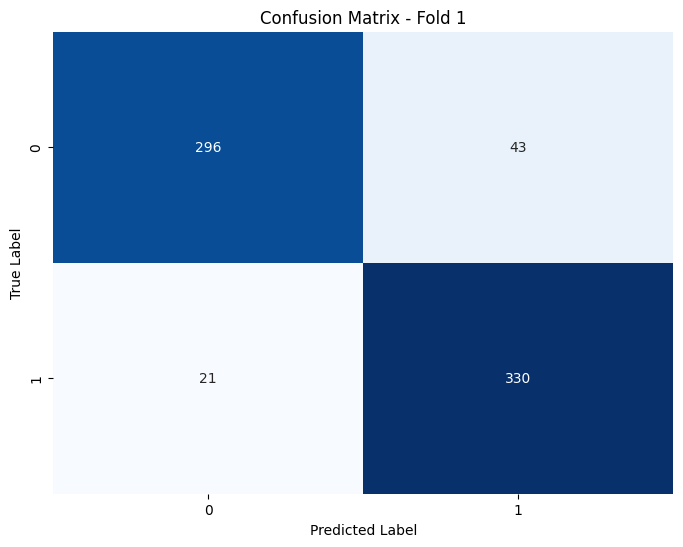


Classification Report - Fold 1
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       339
           1       0.88      0.94      0.91       351

    accuracy                           0.91       690
   macro avg       0.91      0.91      0.91       690
weighted avg       0.91      0.91      0.91       690


Fold 2/5

Fold 2/5


Fold 2 - Epoch 1: 100%|██████████| 87/87 [00:18<00:00,  4.80it/s]


Epoch 1: Train Loss = 0.5707, Val Loss = 0.4001, Accuracy = 83.77%, F1 Score = 0.8366, AUC-ROC = 0.9326
Saved best model for fold 2 at epoch 1.


Fold 2 - Epoch 2: 100%|██████████| 87/87 [00:19<00:00,  4.54it/s]


Epoch 2: Train Loss = 0.3135, Val Loss = 0.2392, Accuracy = 92.03%, F1 Score = 0.9202, AUC-ROC = 0.9658
Saved best model for fold 2 at epoch 2.


Fold 2 - Epoch 3: 100%|██████████| 87/87 [00:20<00:00,  4.20it/s]


Epoch 3: Train Loss = 0.2492, Val Loss = 0.2022, Accuracy = 92.32%, F1 Score = 0.9230, AUC-ROC = 0.9750
Saved best model for fold 2 at epoch 3.


Fold 2 - Epoch 4: 100%|██████████| 87/87 [00:19<00:00,  4.49it/s]


Epoch 4: Train Loss = 0.2175, Val Loss = 0.2690, Accuracy = 90.43%, F1 Score = 0.9037, AUC-ROC = 0.9727


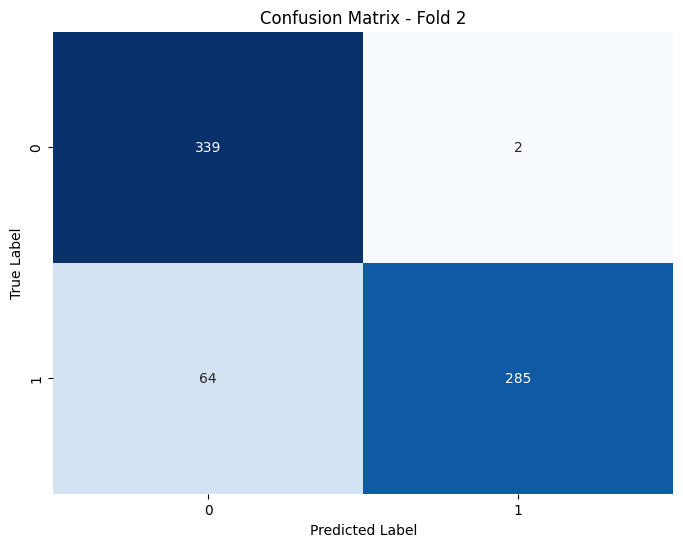


Classification Report - Fold 2
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       341
           1       0.99      0.82      0.90       349

    accuracy                           0.90       690
   macro avg       0.92      0.91      0.90       690
weighted avg       0.92      0.90      0.90       690


Fold 3/5

Fold 3/5


Fold 3 - Epoch 1: 100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


Epoch 1: Train Loss = 0.6285, Val Loss = 0.4334, Accuracy = 83.33%, F1 Score = 0.8330, AUC-ROC = 0.9135
Saved best model for fold 3 at epoch 1.


Fold 3 - Epoch 2: 100%|██████████| 87/87 [00:19<00:00,  4.55it/s]


Epoch 2: Train Loss = 0.3513, Val Loss = 0.2723, Accuracy = 90.87%, F1 Score = 0.9080, AUC-ROC = 0.9620
Saved best model for fold 3 at epoch 2.


Fold 3 - Epoch 3: 100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


Epoch 3: Train Loss = 0.2693, Val Loss = 0.1892, Accuracy = 93.91%, F1 Score = 0.9390, AUC-ROC = 0.9750
Saved best model for fold 3 at epoch 3.


Fold 3 - Epoch 4: 100%|██████████| 87/87 [00:18<00:00,  4.74it/s]


Epoch 4: Train Loss = 0.2523, Val Loss = 0.3075, Accuracy = 91.74%, F1 Score = 0.9174, AUC-ROC = 0.9690


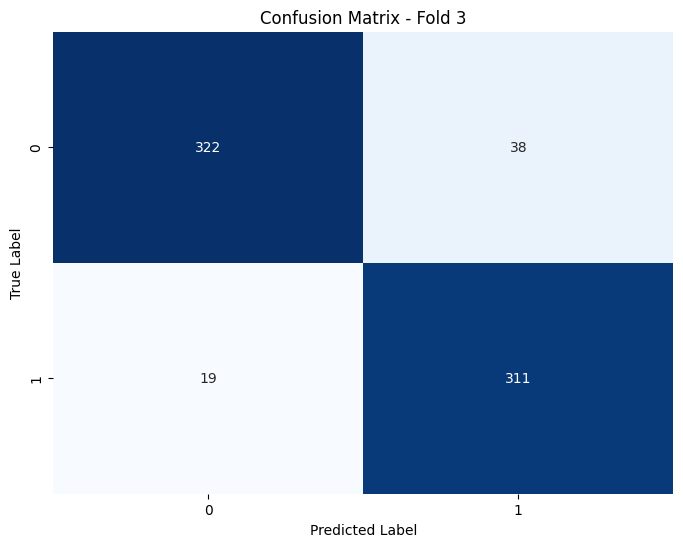


Classification Report - Fold 3
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       360
           1       0.89      0.94      0.92       330

    accuracy                           0.92       690
   macro avg       0.92      0.92      0.92       690
weighted avg       0.92      0.92      0.92       690


Fold 4/5

Fold 4/5


Fold 4 - Epoch 1: 100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


Epoch 1: Train Loss = 0.5944, Val Loss = 0.5863, Accuracy = 66.76%, F1 Score = 0.6350, AUC-ROC = 0.9090
Saved best model for fold 4 at epoch 1.


Fold 4 - Epoch 2: 100%|██████████| 87/87 [00:21<00:00,  3.97it/s]


Epoch 2: Train Loss = 0.3313, Val Loss = 0.3606, Accuracy = 87.66%, F1 Score = 0.8754, AUC-ROC = 0.9472
Saved best model for fold 4 at epoch 2.


Fold 4 - Epoch 3: 100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


Epoch 3: Train Loss = 0.2465, Val Loss = 0.3801, Accuracy = 88.97%, F1 Score = 0.8889, AUC-ROC = 0.9530
Saved best model for fold 4 at epoch 3.


Fold 4 - Epoch 4: 100%|██████████| 87/87 [00:17<00:00,  4.84it/s]


Epoch 4: Train Loss = 0.2029, Val Loss = 0.2334, Accuracy = 89.11%, F1 Score = 0.8910, AUC-ROC = 0.9624
Saved best model for fold 4 at epoch 4.


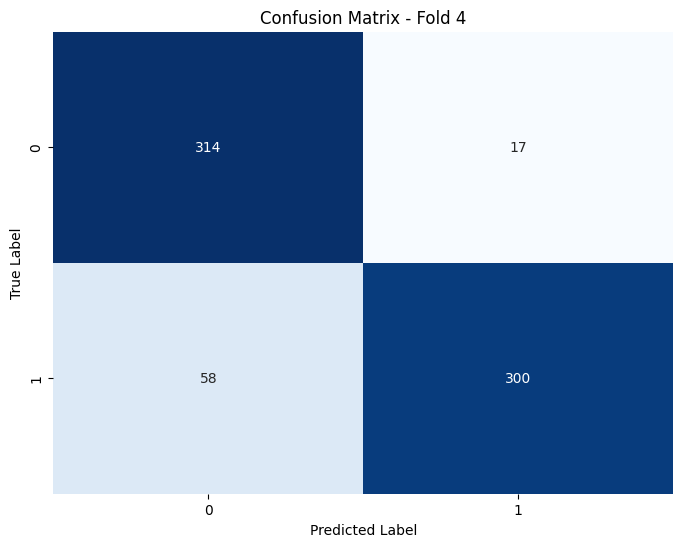


Classification Report - Fold 4
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       331
           1       0.95      0.84      0.89       358

    accuracy                           0.89       689
   macro avg       0.90      0.89      0.89       689
weighted avg       0.90      0.89      0.89       689


Fold 5/5

Fold 5/5


Fold 5 - Epoch 1: 100%|██████████| 87/87 [00:20<00:00,  4.22it/s]


Epoch 1: Train Loss = 0.7053, Val Loss = 0.5208, Accuracy = 75.33%, F1 Score = 0.7405, AUC-ROC = 0.8758
Saved best model for fold 5 at epoch 1.


Fold 5 - Epoch 2: 100%|██████████| 87/87 [00:18<00:00,  4.77it/s]


Epoch 2: Train Loss = 0.3697, Val Loss = 0.2202, Accuracy = 92.45%, F1 Score = 0.9244, AUC-ROC = 0.9639
Saved best model for fold 5 at epoch 2.


Fold 5 - Epoch 3: 100%|██████████| 87/87 [00:18<00:00,  4.69it/s]


Epoch 3: Train Loss = 0.2605, Val Loss = 0.2118, Accuracy = 92.31%, F1 Score = 0.9228, AUC-ROC = 0.9623


Fold 5 - Epoch 4: 100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


Epoch 4: Train Loss = 0.2357, Val Loss = 0.3920, Accuracy = 89.70%, F1 Score = 0.8969, AUC-ROC = 0.9414


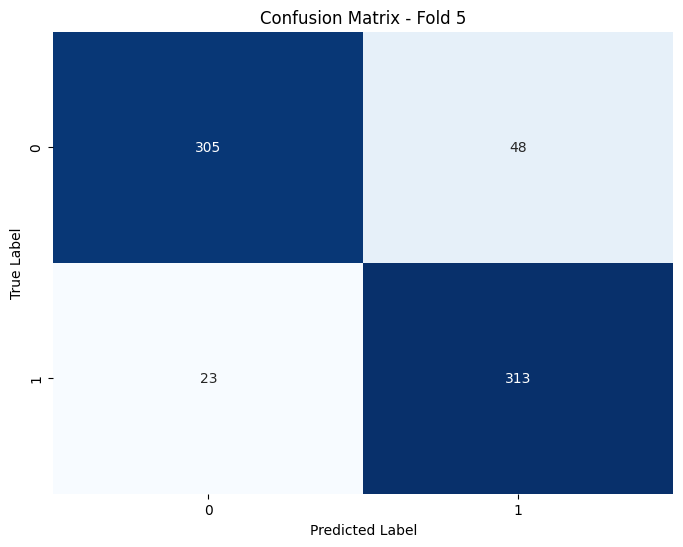


Classification Report - Fold 5
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       353
           1       0.87      0.93      0.90       336

    accuracy                           0.90       689
   macro avg       0.90      0.90      0.90       689
weighted avg       0.90      0.90      0.90       689



In [ ]:
# Set transformers logging to error only
transformers.logging.set_verbosity_error()

# Load best hyperparameters from JSON
with open("best_hyperparams_databalanced.json", "r") as f:
    best_hyperparams = json.load(f)["best_hyperparameters"]
# Print the contents
print(best_hyperparams)
# Constants
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set hyperparameters from JSON
batch_size = best_hyperparams['batch_size']
lr = best_hyperparams['lr']
d_model = best_hyperparams['d_model']
dropout = best_hyperparams['dropout']
nhead = best_hyperparams['nhead']
num_epochs = 4
k_folds = 5

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

# Define Custom BERT Model
class CustomBERTClassifier(nn.Module):
    def __init__(self, config, num_labels, dropout):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits
        else:
            return logits

def tokenize_data(texts, tokenizer):
    return tokenizer(
        texts,
        truncation=True,
        padding='longest',  # Mengubah padding menjadi 'longest' untuk menyesuaikan panjang batch
        return_tensors='pt',
        max_length=128
    )
def plot_confusion_matrix(y_true, y_pred, fold):
    """
    Plot and display confusion matrix for the current fold
    """
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))

    # Add labels and title
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Save and show the plot
    plt.savefig(f'confusion_matrix_fold_{fold}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # Print classification report
    print(f"\nClassification Report - Fold {fold}")
    print(classification_report(y_true, y_pred))

def compute_validation_metrics(model, val_loader, y_val):
    val_predictions = []
    val_probs = []
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += loss.item()
            batch_probs = torch.softmax(logits, dim=1)
            batch_predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(batch_predictions.cpu().numpy())
            val_probs.extend(batch_probs.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions, average='weighted')
    return avg_val_loss, accuracy, f1, val_predictions, val_probs

from tqdm import tqdm

def train_and_evaluate(fold, train_loader, val_loader, y_val):
    config = BertConfig.from_pretrained("bert-base-uncased")
    model = CustomBERTClassifier(config=config, num_labels=len(y_val.unique()), dropout=dropout).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scaler = GradScaler() if torch.cuda.is_available() else None
    best_accuracy = 0

    print(f"\nFold {fold}/{k_folds}")  # Display the fold number

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Create a progress bar for batches within an epoch, and set leave=True to make it disappear at 100%
        with tqdm(total=len(train_loader), desc=f"Fold {fold} - Epoch {epoch + 1}", leave=True) as batch_pbar:
            for batch in train_loader:
                optimizer.zero_grad(set_to_none=True)
                input_ids, attention_mask, labels = [b.to(device) for b in batch]

                # Update to avoid FutureWarning by specifying 'cuda' for autocast
                with torch.amp.autocast('cuda') if torch.cuda.is_available() else nullcontext():
                    loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)

                if scaler:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()

                total_train_loss += loss.item()
                torch.cuda.empty_cache()

                # Update batch progress bar
                batch_pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)

        # Compute validation metrics
        val_loss, accuracy, f1, val_predictions, val_probs = compute_validation_metrics(model, val_loader, y_val)

        # Compute AUC-ROC for each epoch
        if len(np.unique(y_val)) == 2:
            epoch_roc_auc = roc_auc_score(y_val, [prob[1] for prob in val_probs])
        else:
            epoch_roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')

        # Print the epoch results
        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, "
              f"Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.4f}, AUC-ROC = {epoch_roc_auc:.4f}")

        # Check if we need to save the best model for the current fold
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), f'model_best_fold_{fold}_state_dict.pt')
            print(f"Saved best model for fold {fold} at epoch {epoch + 1}.")

    return avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs



# Metrics collection
all_labels = []
all_probs = []
all_preds = []
fold_results = []

# Main KFold loop
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# Main KFold loop with validation dataset creation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_balanced), 1):
    print(f"\nFold {fold}/{k_folds}")

    # Slicing the data
    X_train, X_val = X_train_balanced[train_index], X_train_balanced[val_index]
    y_train, y_val = y_train_balanced.iloc[train_index], y_train_balanced.iloc[val_index]

    # print(f"X_train shape: {X_train.shape}")
    # print(f"X_val shape: {X_val.shape}")
    # print(f"y_train shape: {y_train.shape}")
    # print(f"y_val shape: {y_val.shape}")

    # Convert sparse matrix to dense and then to a list of strings
    train_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_train]
    val_texts = [' '.join(map(str, text.nonzero()[1])) for text in X_val]

    # print(f"Number of train texts: {len(train_texts)}")
    # print(f"Number of val texts: {len(val_texts)}")

    # Tokenize both training and validation data
    train_encodings = tokenize_data(train_texts, tokenizer)
    val_encodings = tokenize_data(val_texts, tokenizer)

    # Convert labels to tensors
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)

    # print(f"y_train_tensor shape: {y_train_tensor.shape}")
    # print(f"y_val_tensor shape: {y_val_tensor.shape}")

    # Create both training and validation datasets
    try:
        train_dataset = TensorDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            y_train_tensor
        )
        # print(f"Successfully created train_dataset with size: {len(train_dataset)}")

        val_dataset = TensorDataset(
            val_encodings['input_ids'],
            val_encodings['attention_mask'],
            y_val_tensor
        )
        # print(f"Successfully created val_dataset with size: {len(val_dataset)}")

    except AssertionError as e:
        print("Error creating datasets:")
        print(f"Train Input IDs size: {train_encodings['input_ids'].size()}")
        print(f"Train Attention Mask size: {train_encodings['attention_mask'].size()}")
        print(f"Train Labels size: {y_train_tensor.size()}")
        print(f"Val Input IDs size: {val_encodings['input_ids'].size()}")
        print(f"Val Attention Mask size: {val_encodings['attention_mask'].size()}")
        print(f"Val Labels size: {y_val_tensor.size()}")
        raise e

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Train and evaluate for the current fold
    avg_train_loss, val_loss, accuracy, f1, val_predictions, val_probs = train_and_evaluate(fold, train_loader, val_loader, y_val)
    fold_results.append((avg_train_loss, val_loss, accuracy, f1))

    # Plot confusion matrix and print classification report for this fold
    plot_confusion_matrix(y_val, val_predictions, fold)

    # Collect predictions and true labels
    all_labels.extend(y_val.tolist())
    all_preds.extend(val_predictions)
    all_probs.extend(val_probs)

In [ ]:
# Jika hanya ada dua kelas, pastikan bentuk probabilitas cocok
if len(np.unique(all_labels)) == 2:
    # Ambil probabilitas untuk kelas positif (kelas 1)
    all_probs = np.array([prob[1] for prob in all_probs])
    roc_auc = roc_auc_score(all_labels, all_probs)
else:
    # Untuk multi-kelas, biarkan all_probs dalam bentuk asli
    all_probs = np.array(all_probs)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"Average AUC-ROC Across All Folds: {roc_auc:.4f}")

Average AUC-ROC Across All Folds: 0.9548


Average Metrics Across Folds:
Train_loss: 0.2292
Val_loss: 0.3054
Accuracy: 0.9034
F1_score: 0.9032
Auc_roc: 0.9548


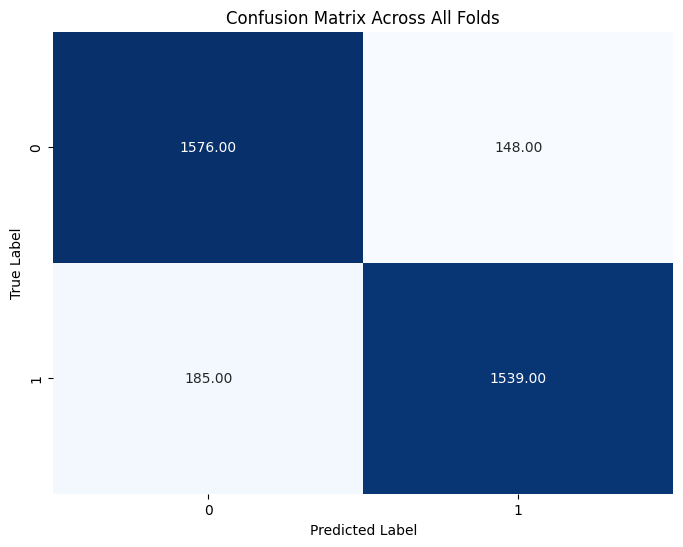


Classification Report for All Folds:
              precision    recall  f1-score   support

           0     0.8949    0.9142    0.9044      1724
           1     0.9123    0.8927    0.9024      1724

    accuracy                         0.9034      3448
   macro avg     0.9036    0.9034    0.9034      3448
weighted avg     0.9036    0.9034    0.9034      3448



In [ ]:
# Average Metrics Across Folds
avg_metrics = {
    key: np.mean([result[idx] for result in fold_results])
    for idx, key in enumerate(['train_loss', 'val_loss', 'accuracy', 'f1_score'])
}
avg_metrics['auc_roc'] = roc_auc  # Tambahkan AUC-ROC rata-rata

print("Average Metrics Across Folds:")
for key, value in avg_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# Calculate and plot the overall confusion matrix after all folds
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Across All Folds")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report for All Folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, digits=4))


# **Visualisasi KFold Cross Validation**

In [3]:
import os

# Ensure the directory exists
output_dir = '/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/result/'
os.makedirs(output_dir, exist_ok=True)

## Hasil Data Default Without Hyperparameter Tuning

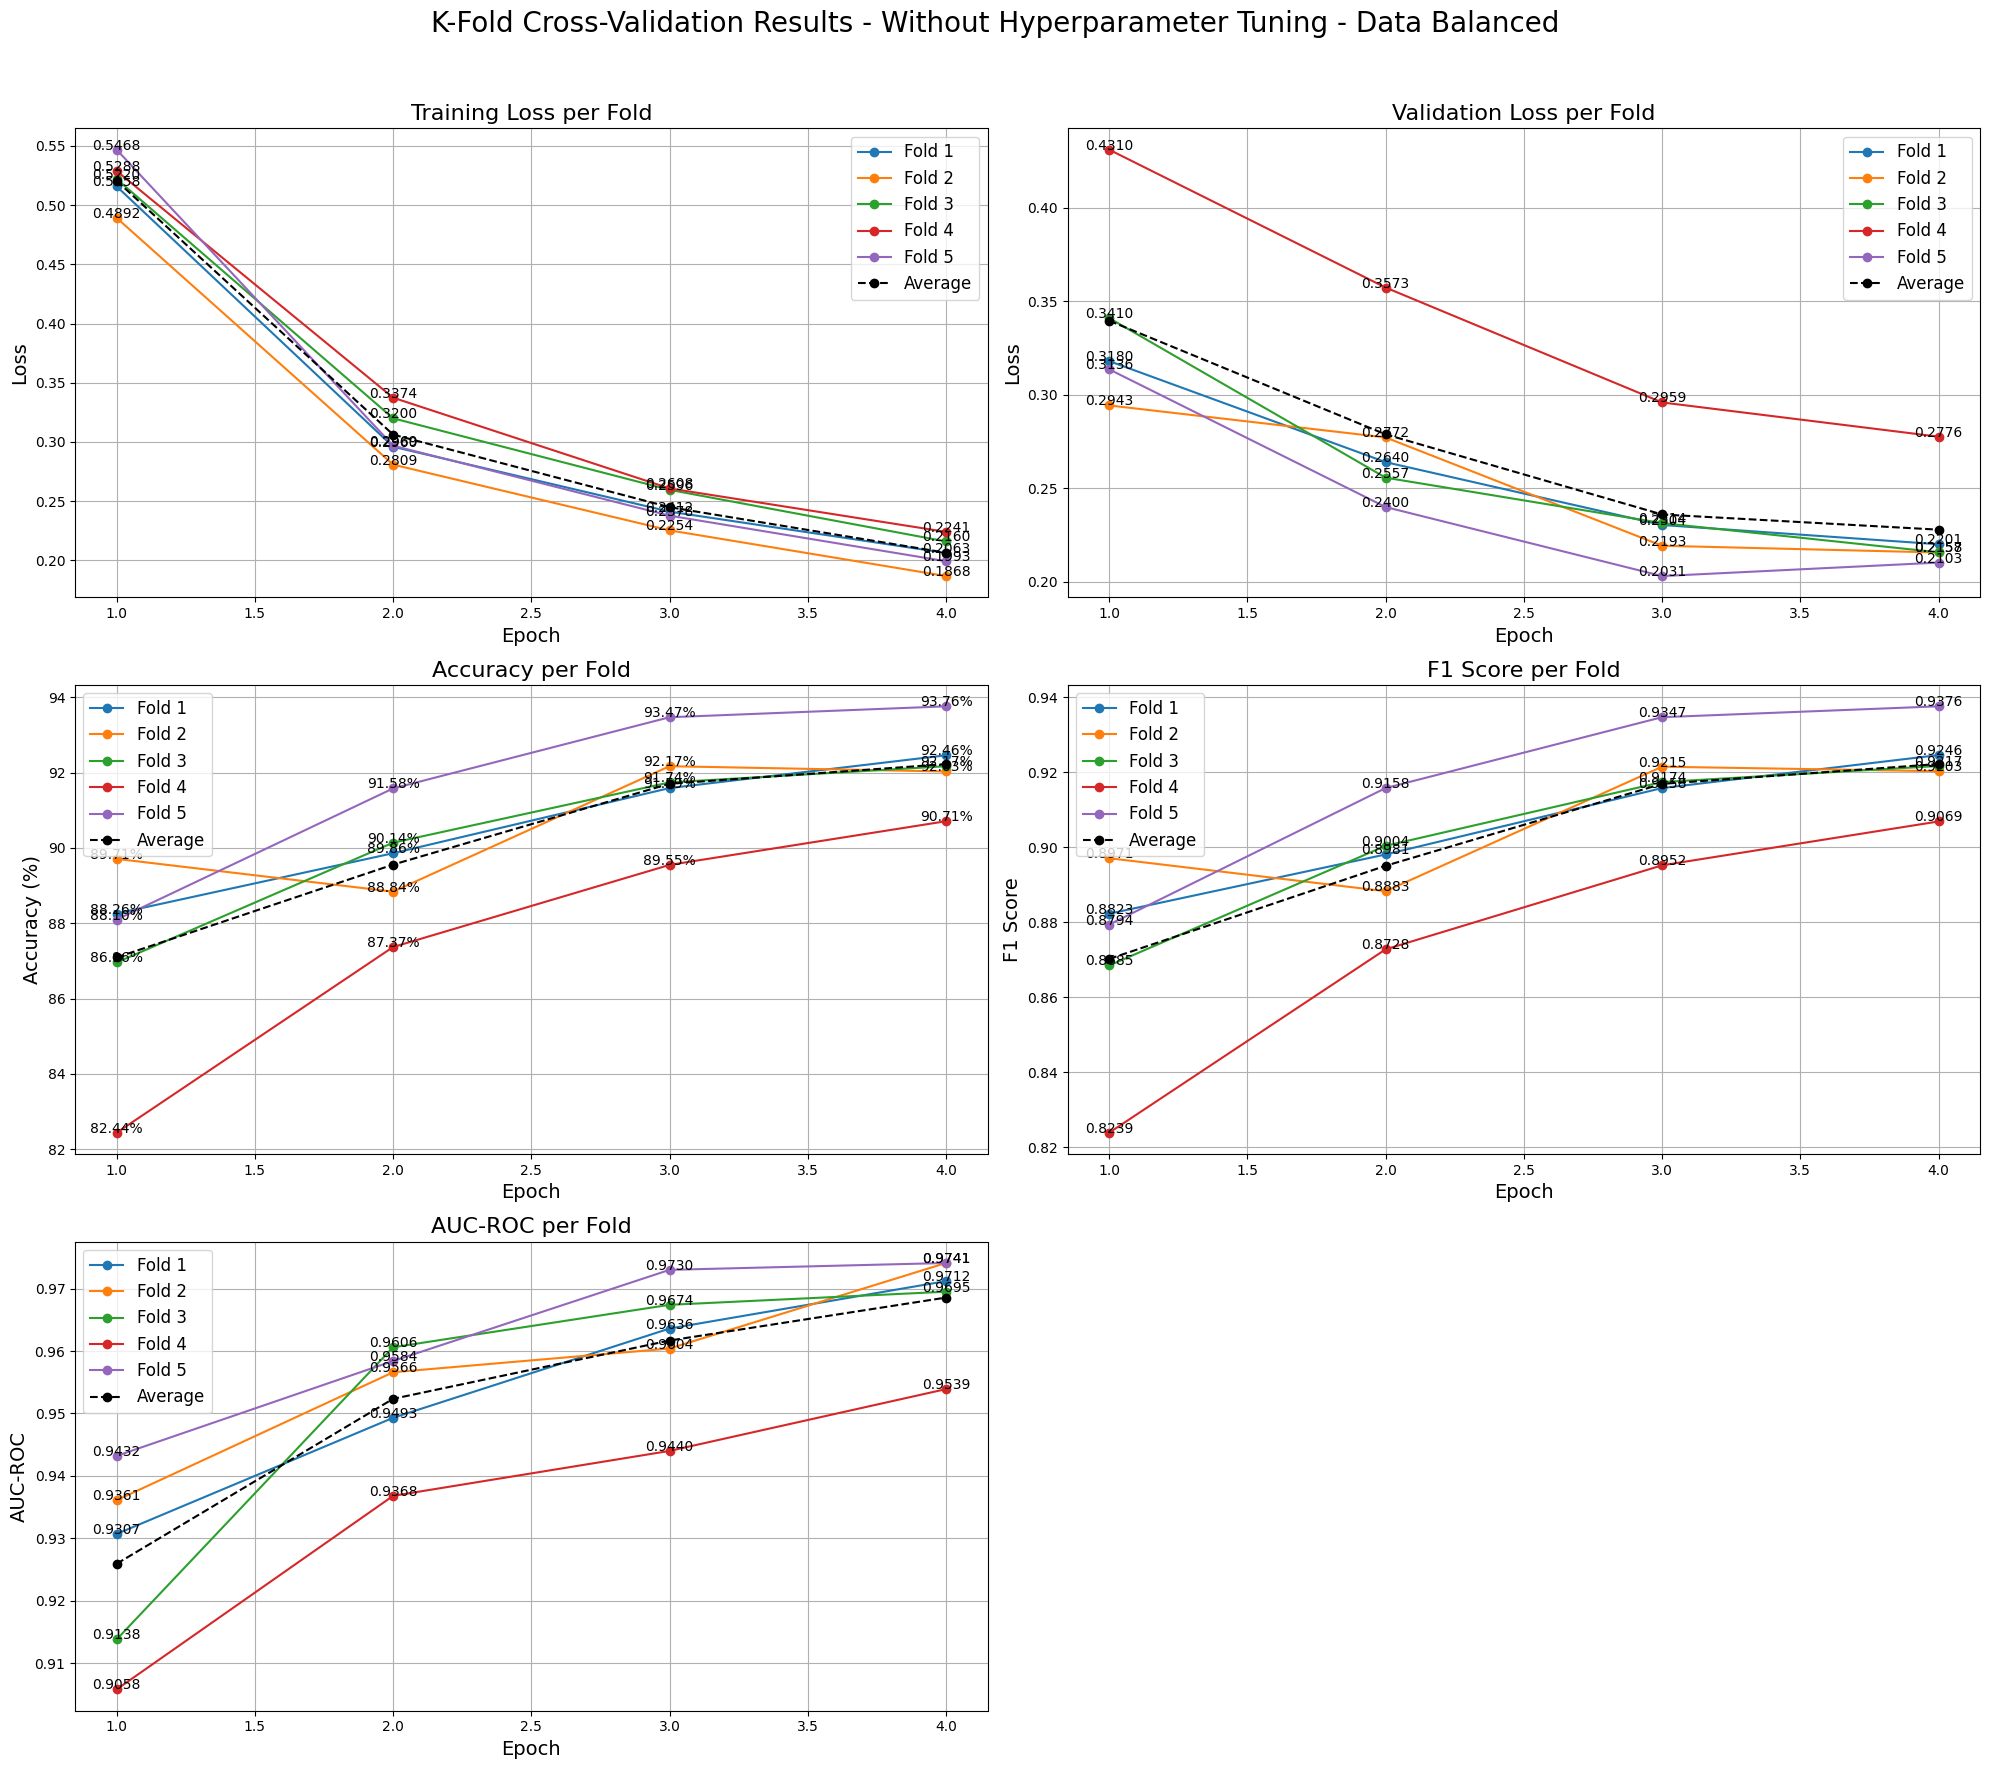

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data kinerja setiap fold berdasarkan log yang diberikan
folds = 5
epochs = [1, 2, 3, 4]  # Jumlah epoch yang digunakan pada masing-masing fold
train_loss = [
    [0.5158, 0.2960, 0.2412, 0.2063],  # Fold 1
    [0.4892, 0.2809, 0.2254, 0.1868],  # Fold 2
    [0.5220, 0.3200, 0.2596, 0.2160],  # Fold 3
    [0.5288, 0.3374, 0.2608, 0.2241],  # Fold 4
    [0.5468, 0.2969, 0.2378, 0.1993]   # Fold 5
]

val_loss = [
    [0.3180, 0.2640, 0.2304, 0.2201],  # Fold 1
    [0.2943, 0.2772, 0.2193, 0.2157],  # Fold 2
    [0.3410, 0.2557, 0.2314, 0.2158],  # Fold 3
    [0.4310, 0.3573, 0.2959, 0.2776],  # Fold 4
    [0.3136, 0.2400, 0.2031, 0.2103]   # Fold 5
]

accuracy = [
    [88.26, 89.86, 91.59, 92.46],  # Fold 1
    [89.71, 88.84, 92.17, 92.03],  # Fold 2
    [86.96, 90.14, 91.74, 92.17],  # Fold 3
    [82.44, 87.37, 89.55, 90.71],  # Fold 4
    [88.10, 91.58, 93.47, 93.76]   # Fold 5
]

f1_score = [
    [0.8823, 0.8981, 0.9158, 0.9246],  # Fold 1
    [0.8971, 0.8883, 0.9215, 0.9203],  # Fold 2
    [0.8685, 0.9004, 0.9174, 0.9217],  # Fold 3
    [0.8239, 0.8728, 0.8952, 0.9069],  # Fold 4
    [0.8794, 0.9158, 0.9347, 0.9376]   # Fold 5
]

auc_roc = [
    [0.9307, 0.9493, 0.9636, 0.9712],  # Fold 1
    [0.9361, 0.9566, 0.9604, 0.9741],  # Fold 2
    [0.9138, 0.9606, 0.9674, 0.9695],  # Fold 3
    [0.9058, 0.9368, 0.9440, 0.9539],  # Fold 4
    [0.9432, 0.9584, 0.9730, 0.9741]   # Fold 5
]


# Rata-rata metrik di seluruh fold
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_accuracy = np.mean(accuracy, axis=0)
avg_f1_score = np.mean(f1_score, axis=0)
avg_auc_roc = np.mean(auc_roc, axis=0)

# Plot untuk setiap fold dan rata-rata
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Grafik Training Loss
for i in range(folds):
    axs[0, 0].plot(epochs, train_loss[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(train_loss[i]):
        axs[0, 0].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[0, 0].plot(epochs, avg_train_loss, color='black', linestyle='--', label='Average', marker='o')
axs[0, 0].set_title('Training Loss per Fold', fontsize=16)
axs[0, 0].set_xlabel('Epoch', fontsize=14)
axs[0, 0].set_ylabel('Loss', fontsize=14)
axs[0, 0].legend(loc='best', fontsize=12)
axs[0, 0].grid(True)

# Grafik Validation Loss
for i in range(folds):
    axs[0, 1].plot(epochs, val_loss[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(val_loss[i]):
        axs[0, 1].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[0, 1].plot(epochs, avg_val_loss, color='black', linestyle='--', label='Average', marker='o')
axs[0, 1].set_title('Validation Loss per Fold', fontsize=16)
axs[0, 1].set_xlabel('Epoch', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].legend(loc='best', fontsize=12)
axs[0, 1].grid(True)

# Grafik Accuracy
for i in range(folds):
    axs[1, 0].plot(epochs, accuracy[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(accuracy[i]):
        axs[1, 0].text(epochs[j], value, f'{value:.2f}%', fontsize=10, ha='center')
axs[1, 0].plot(epochs, avg_accuracy, color='black', linestyle='--', label='Average', marker='o')
axs[1, 0].set_title('Accuracy per Fold', fontsize=16)
axs[1, 0].set_xlabel('Epoch', fontsize=14)
axs[1, 0].set_ylabel('Accuracy (%)', fontsize=14)
axs[1, 0].legend(loc='best', fontsize=12)
axs[1, 0].grid(True)

# Grafik F1 Score
for i in range(folds):
    axs[1, 1].plot(epochs, f1_score[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(f1_score[i]):
        axs[1, 1].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[1, 1].plot(epochs, avg_f1_score, color='black', linestyle='--', label='Average', marker='o')
axs[1, 1].set_title('F1 Score per Fold', fontsize=16)
axs[1, 1].set_xlabel('Epoch', fontsize=14)
axs[1, 1].set_ylabel('F1 Score', fontsize=14)
axs[1, 1].legend(loc='best', fontsize=12)
axs[1, 1].grid(True)

# Grafik AUC-ROC
for i in range(folds):
    axs[2, 0].plot(epochs, auc_roc[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(auc_roc[i]):
        axs[2, 0].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[2, 0].plot(epochs, avg_auc_roc, color='black', linestyle='--', label='Average', marker='o')
axs[2, 0].set_title('AUC-ROC per Fold', fontsize=16)
axs[2, 0].set_xlabel('Epoch', fontsize=14)
axs[2, 0].set_ylabel('AUC-ROC', fontsize=14)
axs[2, 0].legend(loc='best', fontsize=12)
axs[2, 0].grid(True)

# Kosongkan subplot terakhir
axs[2, 1].axis('off')

plt.suptitle('K-Fold Cross-Validation Results - Without Hyperparameter Tuning - Data Balanced', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title better
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/result/Data_Balanced-With_Best_Hyperparameter_Tuning.png')
plt.show()


### Summary

Fold 1:

Train Loss: 0.2159

Val Loss: 0.2563

Accuracy: 92.86%

F1 Score: 0.9235

AUC-ROC: 0.9638

.
Fold 2:

Train Loss: 0.2387

Val Loss: 0.2222

Accuracy: 90.86%

F1 Score: 0.9114

AUC-ROC: 0.9619

.
Fold 3:

Train Loss: 0.1552

Val Loss: 0.2260

Accuracy: 94.52%

F1 Score: 0.9410

AUC-ROC: 0.9508

.
Fold 4:

Train Loss: 0.2167

Val Loss: 0.2057

Accuracy: 93.73%

F1 Score: 0.9395

AUC-ROC: 0.9358

.
Fold 5:

Train Loss: 0.2033

Val Loss: 0.1786
Accuracy: 94.09%
F1 Score: 0.9436
AUC-ROC: 0.9547

### Kesimpulan
Berdasarkan perbandingan kinerja di atas:

Fold 1 memiliki Train Loss dan Val Loss terendah, serta Accuracy dan F1 Score tertinggi di antara ketiga fold. Ini menunjukkan bahwa Fold 1 memiliki kinerja terbaik dalam memprediksi dengan akurasi tinggi dan kesalahan terendah, baik pada data pelatihan maupun data validasi.

Fold 2 menonjol pada AUC-ROC yang lebih tinggi, menunjukkan kemampuannya dalam membedakan kelas, namun memiliki loss yang lebih tinggi dan akurasi yang lebih rendah.

Fold 3 menunjukkan hasil yang lebih stabil tetapi kurang unggul dibanding Fold 1 pada sebagian besar metrik.


**Fold terbaik adalah Fold 1, karena memiliki kombinasi terbaik dari loss terendah dan akurasi serta F1 score yang paling tinggi, yang menunjukkan keseimbangan antara performa pada training dan validation.**

## Hasil Data Default Without Hyperparameter Tuning

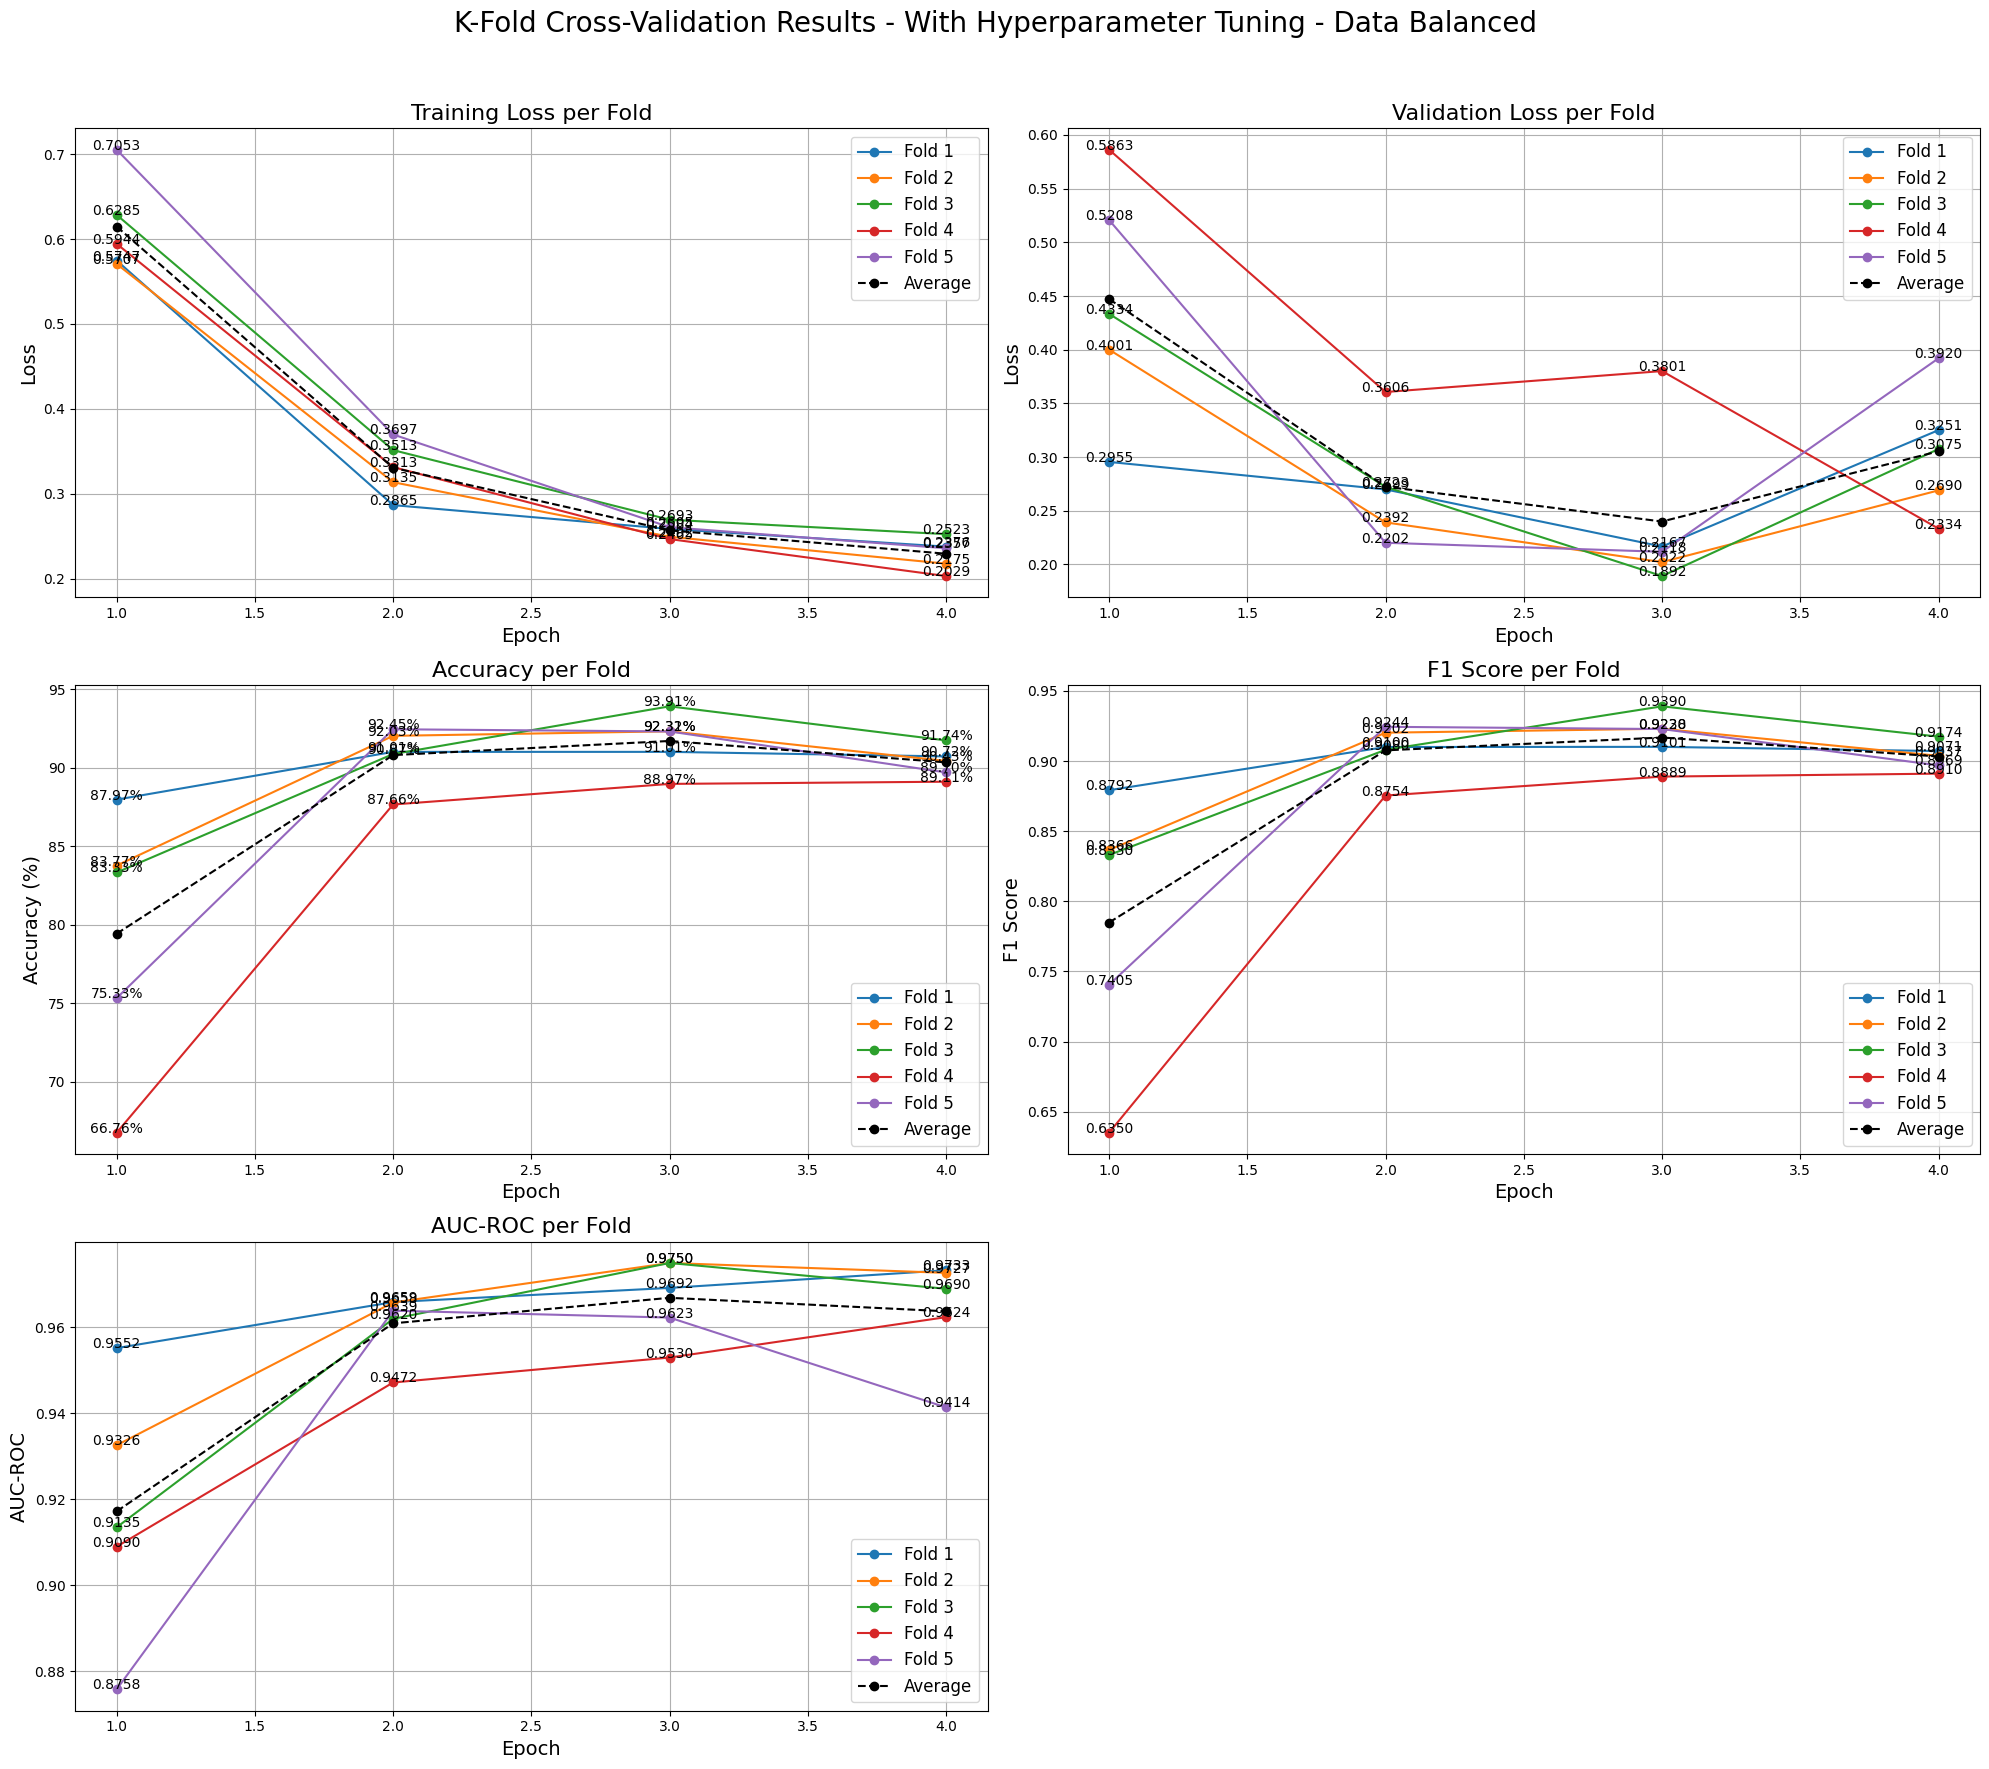

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data kinerja setiap fold
folds = 5
epochs = [1, 2, 3, 4]
train_loss = [
    [0.5747, 0.2865, 0.2584, 0.2376],
    [0.5707, 0.3135, 0.2492, 0.2175],
    [0.6285, 0.3513, 0.2693, 0.2523],
    [0.5944, 0.3313, 0.2465, 0.2029],
    [0.7053, 0.3697, 0.2605, 0.2357]
]

val_loss = [
    [0.2955, 0.2699, 0.2167, 0.3251],
    [0.4001, 0.2392, 0.2022, 0.2690],
    [0.4334, 0.2723, 0.1892, 0.3075],
    [0.5863, 0.3606, 0.3801, 0.2334],
    [0.5208, 0.2202, 0.2118, 0.3920]
]

accuracy = [
    [87.97, 91.01, 91.01, 90.72],
    [83.77, 92.03, 92.32, 90.43],
    [83.33, 90.87, 93.91, 91.74],
    [66.76, 87.66, 88.97, 89.11],
    [75.33, 92.45, 92.31, 89.70]
]

f1_score = [
    [0.8792, 0.9100, 0.9101, 0.9071],
    [0.8366, 0.9202, 0.9230, 0.9037],
    [0.8330, 0.9080, 0.9390, 0.9174],
    [0.6350, 0.8754, 0.8889, 0.8910],
    [0.7405, 0.9244, 0.9228, 0.8969]
]

auc_roc = [
    [0.9552, 0.9659, 0.9692, 0.9733],
    [0.9326, 0.9658, 0.9750, 0.9727],
    [0.9135, 0.9620, 0.9750, 0.9690],
    [0.9090, 0.9472, 0.9530, 0.9624],
    [0.8758, 0.9639, 0.9623, 0.9414]
]


# Rata-rata metrik di seluruh fold
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
avg_accuracy = np.mean(accuracy, axis=0)
avg_f1_score = np.mean(f1_score, axis=0)
avg_auc_roc = np.mean(auc_roc, axis=0)

# Plot untuk setiap fold dan rata-rata
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Grafik Training Loss
for i in range(folds):
    axs[0, 0].plot(epochs, train_loss[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(train_loss[i]):
        axs[0, 0].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[0, 0].plot(epochs, avg_train_loss, color='black', linestyle='--', label='Average', marker='o')
axs[0, 0].set_title('Training Loss per Fold', fontsize=16)
axs[0, 0].set_xlabel('Epoch', fontsize=14)
axs[0, 0].set_ylabel('Loss', fontsize=14)
axs[0, 0].legend(loc='best', fontsize=12)
axs[0, 0].grid(True)

# Grafik Validation Loss
for i in range(folds):
    axs[0, 1].plot(epochs, val_loss[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(val_loss[i]):
        axs[0, 1].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[0, 1].plot(epochs, avg_val_loss, color='black', linestyle='--', label='Average', marker='o')
axs[0, 1].set_title('Validation Loss per Fold', fontsize=16)
axs[0, 1].set_xlabel('Epoch', fontsize=14)
axs[0, 1].set_ylabel('Loss', fontsize=14)
axs[0, 1].legend(loc='best', fontsize=12)
axs[0, 1].grid(True)

# Grafik Accuracy
for i in range(folds):
    axs[1, 0].plot(epochs, accuracy[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(accuracy[i]):
        axs[1, 0].text(epochs[j], value, f'{value:.2f}%', fontsize=10, ha='center')
axs[1, 0].plot(epochs, avg_accuracy, color='black', linestyle='--', label='Average', marker='o')
axs[1, 0].set_title('Accuracy per Fold', fontsize=16)
axs[1, 0].set_xlabel('Epoch', fontsize=14)
axs[1, 0].set_ylabel('Accuracy (%)', fontsize=14)
axs[1, 0].legend(loc='best', fontsize=12)
axs[1, 0].grid(True)

# Grafik F1 Score
for i in range(folds):
    axs[1, 1].plot(epochs, f1_score[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(f1_score[i]):
        axs[1, 1].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[1, 1].plot(epochs, avg_f1_score, color='black', linestyle='--', label='Average', marker='o')
axs[1, 1].set_title('F1 Score per Fold', fontsize=16)
axs[1, 1].set_xlabel('Epoch', fontsize=14)
axs[1, 1].set_ylabel('F1 Score', fontsize=14)
axs[1, 1].legend(loc='best', fontsize=12)
axs[1, 1].grid(True)

# Grafik AUC-ROC
for i in range(folds):
    axs[2, 0].plot(epochs, auc_roc[i], label=f'Fold {i+1}', marker='o')
    for j, value in enumerate(auc_roc[i]):
        axs[2, 0].text(epochs[j], value, f'{value:.4f}', fontsize=10, ha='center')
axs[2, 0].plot(epochs, avg_auc_roc, color='black', linestyle='--', label='Average', marker='o')
axs[2, 0].set_title('AUC-ROC per Fold', fontsize=16)
axs[2, 0].set_xlabel('Epoch', fontsize=14)
axs[2, 0].set_ylabel('AUC-ROC', fontsize=14)
axs[2, 0].legend(loc='best', fontsize=12)
axs[2, 0].grid(True)

# Kosongkan subplot terakhir
axs[2, 1].axis('off')

plt.suptitle('K-Fold Cross-Validation Results - With Hyperparameter Tuning - Data Balanced', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title better
plt.savefig('/content/gdrive/My Drive/ASDOS/template/Topik4_Phishing URL Detection Using BERT-Based Transformer Models/result/Data_Balanced-With_Hyperparameter_Tuning.png')
plt.show()


### Summary

Fold 1:

Train Loss: 0.4674

Val Loss: 0.3486

Accuracy: 87.14

F1 Score: 0.8116

AUC-ROC: 0.6527

.

Fold 2:

Train Loss: 0.4272

Val Loss: 0.4523

Accuracy: 84.06

F1 Score: 0.7678

AUC-ROC: 0.8218

.

Fold 3:

Train Loss: 0.4603

Val Loss: 0.3738

Accuracy: 85.51

F1 Score: 0.7883

AUC-ROC: 0.6734

### Kesimpulan
Fold 1 menunjukkan performa terbaik dalam hal akurasi dan F1 score.
Fold 2 memiliki train loss terendah dan AUC-ROC tertinggi.
Fold 3 memiliki val loss yang baik, tetapi tidak sebaik Fold 1 dalam metrik lainnya.


**Fold terbaik adalah Fold 1, karena memiliki kombinasi terbaik dari loss terendah dan akurasi serta F1 score yang paling tinggi, yang menunjukkan keseimbangan antara performa pada training dan validation.**